# 0.参数设定

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

from jax.config import config
config.update("jax_enable_x64", True)

import pickle, re, os, time
import jax, optax, jax.random as rd, jax.numpy as jnp, flax.linen as nn, numpy as np, matplotlib.pyplot as plt
from functools import partial
from DataLoader import DataLoader,take_data,Generation_DataSet
from optical_flax.fiber_system import get_data, Tx_data
from optical_flax.fiber_tx import  wdm_base
from optical_flax.fiber_channel import edfa, ssfm, manakov_ssf
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp, NNSSFM,Dense_net
from optical_flax.models import Transformer, CNN, xi_config,H_config
from optical_flax.initializers import fdbp_init, near_zeros,ones
from optical_flax.utils import realize,show_tree
from commplax.module.core import Signal
from commplax import xop
import argparse
import scipy.constants as const
from optical_flax.operator import fft,ifft,fftfreq,fftshift
import jaxlib
DeviceArray = jaxlib.xla_extension.DeviceArray



from flax import struct
from typing import Any, NamedTuple, Iterable, Callable, Optional
from typing import Callable
from commplax.module.core import Signal
Array = Any

from optical_flax.fiber_tx import QAM
from commplax import comm

###### Global parameters 

C = const.c                             # speed of light [m/s]
D = 1.65e-5                             # [s/m^2]
fc = 193414489032258                    # [Hz]
alphaB = 0.0002                         # [dB/m]
gamma = 0.0016567                       # [/W/m]
alpha = alphaB / 10 * np.log(10.)       # [/m]
lamb = C/fc                             # [m]
beta2 = -(D*lamb**2)/(2*np.pi*C)        # [s^2/m]

@struct.dataclass
class MySignal:
    val: Array    # [Nfft,Nmodes]
    Fs: float=struct.field(pytree_node=False)
    sps: int=struct.field(pytree_node=False)
    Nch: int=struct.field(pytree_node=False)
    freqspace: float=struct.field(pytree_node=False)

    def __add__(self,other):
        return  MySignal(val=self.val + other.val, sps=self.sps, Fs=self.Fs, Nch=self.Nch, freqspace=self.freqspace)
    
    def __sub__(self,other):
        return  MySignal(val=self.val - other.val, sps=self.sps, Fs=self.Fs, Nch=self.Nch, freqspace=self.freqspace)


    def __mul__(self,other):
        return  MySignal(val=self.val * other.val, sps=self.sps, Fs=self.Fs, Nch=self.Nch, freqspace=self.freqspace)

    def __truediv__(self,other):
        return  MySignal(val=self.val / other.val, sps=self.sps, Fs=self.Fs, Nch=self.Nch, freqspace=self.freqspace)
    


setting = 'Huawei'

if setting == 'Huawei':
    ## Hua Wei setting
    
    span_length = 80e3                      # [m]
    span_number = 25                        # [1]
    Nch = 19                                # [1]
    power = 3                               # [dBm]
    Rs = 190e9                              # [Hz]
    freqspace = 220e9                       # [Hz]
    sps = 32                                # tx sps
    sps_single = 2                          # cssfm single channel sps
    pulse_taps = 4096
    Nmodes = 2
    Fs = Rs * sps
    Nsymb = 10000
    Nfft = Nsymb*sps


elif setting == 'Toy':
    ## Toy setting
    
    span_length = 100e3                     # [m]
    span_number = 1                         # [1]
    Nch = 3                                 # [1]
    power = 10                              # [dBm]
    Rs = 10e9                               # [Hz]
    freqspace = 50e9                        # [Hz]
    sps = 16                                # tx sps
    sps_single = 2                          # cssfm single channel sps
    Fs = Rs * sps
    Nsymb = 256
    Nmodes=1
    pulse_taps = 4096
    Nfft = Nsymb*sps



def Tx_signal(*args,**kwargs):
    sigWDM, symbWDM, param = Tx_data(*args,**kwargs)
    wdm_signal = MySignal(val=sigWDM, sps=param.SpS, Fs=param.Rs*param.SpS, Nch=param.Nch, freqspace=param.freqSpac)
    return wdm_signal,symbWDM,param

def show_power(E):
    print('mean signal power: %g [W]' % jnp.mean(jnp.abs(E.val)**2))

from functools import wraps
def make_init(f):
    @wraps(f)
    def _f(key, *args, **kwargs):
        return f(*args, **kwargs)
    
    return _f

In [3]:
def wdm_merge(E):
    # E.val.shape  [Nfft,Nch,Nmodes]
    Nfft = E.val.shape[0]
    freqGrid = jnp.arange(-int(E.Nch/2), int(E.Nch/2)+1,1) * E.freqspace
    wdm_wave = wdm_base(Nfft, E.Fs, freqGrid) # [Nfft, Nch]
    x = jnp.sum(E.val * wdm_wave[...,None], axis=-2)
    return MySignal(val=x,sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)



def exp_integral(z: float, alpha:float = alpha, span_length:float=span_length)->DeviceArray:
    '''
       P(z) = exp( -alpha *(z % Lspan))
       exp_integral(z) = int_{0}^{z} P(z) dz
    '''
    k = z // span_length
    z0 = z % span_length

    return k * (1 - jnp.exp(-alpha * span_length)) / alpha + (1- jnp.exp(-alpha * z0)) / alpha


def Leff1(z, dz, alpha=alpha, span_length=span_length):
    ''' 
    split form 1: no normalization
    '''
    return dz

def Leff2(z, dz, alpha=alpha, span_length=span_length):
    '''
    split form 1: normalization
    '''
    return exp_integral(z + dz) - exp_integral(z)

def get_omega(Fs:int, Nfft:int)->DeviceArray:
    ''' 
    get signal fft angular frequency.
    Input:
        Fs: sampling frequency. [Hz]
        Nfft: number of sampling points. 
    Output:
        omega:DeviceArray [Nfft,]
    '''
    return 2*np.pi*Fs*fftfreq(Nfft)


def H1(dz, E):
    ''' 
    split form 1: no normalization

    Input:
        dz: float
        E: MySignal. [Nfft, Nmodes] or [batch, Nfft, Nmodes]
    Output:
        [Nfft]
    '''
    Nfft = E.val.shape[-2]
    omega = get_omega(E.Fs, Nfft)
    return jnp.exp(-alpha/2*dz - 1j * (beta2/2) * (omega**2) * dz)

def H2(dz, E):
    ''' 
    split form 2: normalization

    Input:
        dz: float
        E: MySignal. [Nfft, Nmodes] or [batch, Nfft, Nmodes]
    Output:
        [Nfft]
    '''
    Nfft = E.val.shape[-2]
    omega = get_omega(E.Fs, Nfft)
    return jnp.exp(-1j * (beta2/2) * (omega**2) * dz)


def h1(dz, E, dtaps):
    ''' 
    split form 1: no normalization

    Input:
        dz: float
        E: MySignal. [Nfft, Nmodes]
    Output:
        [dtaps]
    '''
    omega = get_omega(E.Fs, dtaps)
    kernel = jnp.exp(-alpha/2*dz - 1j * (beta2/2) * (omega**2) * dz)
    return fftshift(ifft(kernel))

def h2(dz, E, dtaps):
    ''' 
    split form 2: normalization

    Input:
        dz: float
        E: MySignal. [Nfft, Nmodes]
    Output:
        [Nfft]
    '''
    omega = get_omega(E.Fs, dtaps)
    kernel = jnp.exp(-1j * (beta2/2) * (omega**2) * dz)
    return fftshift(ifft(kernel))



def L2(x):
    return jnp.sqrt(jnp.mean(jnp.abs(x)**2))

def relative_L2(x,y):
    return L2(x-y) / L2(x)

def MSE(x,y):
    return jnp.mean(jnp.abs(x-y)**2)

def test_convergence(E, method, dz,length=80e3):
    Eo = []
    loss = []
    for h in dz:
        Eo.append(method(E, length,h))
    
    for i in range(len(dz)-1):
        loss.append(relative_L2(Eo[i].val, Eo[i+1].val).item())

    return Eo,loss


def rx(E: MySignal, chid:int, new_sps:int) -> MySignal:
    ''' 
    Get single channel information from WDM signal.
    Input:
        E: 1D array. WDM signal. (Nfft,Nmodes)  or  (Nfft, Nch, Nmodes)
        k: channel id.  [0,1,2,...,Nch-1]
        new_sps
    Output:
        E0: single channel signal. (Nfft,Nmodes)
    '''
    assert E.sps % new_sps == 0
    k = chid - E.Nch // 2
    Nfft = E.val.shape[0]
    Fs = E.Fs
    freqspace = E.freqspace
    t = jnp.linspace(0,1/Fs*Nfft, Nfft)
    omega = get_omega(E.Fs, Nfft)
    f = omega/(2*np.pi)
    x0 = ifft(jnp.roll(fft(E.val, axis=0) * (jnp.abs(f - k*freqspace)<freqspace/2)[:,None], -k*int(freqspace/Fs*Nfft), axis=0), axis=0)
    rate = E.sps // new_sps
    return MySignal(val=x0[::rate,:], sps=new_sps, Fs=E.Fs/rate, Nch=E.Nch, freqspace=E.freqspace)

def wdm_split(E:MySignal,  new_sps:int) -> MySignal:
    '''' 
    Get every single channel information from WDM signal.
    Input:
        E: 1D array. WDM signal. (Nfft,Nmodes)
        new_sps: Output sps.
    Output:
        E: single channel signal. (Nfft, Nch, Nmodes)
    '''

    signal = []
    E0 = jax.vmap(rx, in_axes=(None, 0, None), out_axes=1)(E, jnp.arange(E.Nch), new_sps)
    return E0

batch_wdm_split = jax.vmap(wdm_split, in_axes=(0,None), out_axes=0)

def freq(x):
    return jnp.abs(fftshift(fft(x)))

# 1.SSFM

In [4]:
from optical_flax.operator import circFilter

@partial(jax.jit, static_argnums=(3))
def L(E:MySignal, z:float, dz:float, H:Callable=H1) -> MySignal: 
    ''' 
    Linear operator with full FFT convolution.
    Input:
        E: E.val  [Nfft,Nmodes]
        z: operator start position.
        dz: operator distance.
        H: kernel function. [Nfft,]
    Output:
        E: E.val [Nfft, Nmodes]
    '''
    kernel = H(dz, E)   # [Nfft]
    x = ifft(fft(E.val, axis=0) * kernel[:,None], axis=0)
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


@partial(jax.jit, static_argnums=(3,4))
def Lh(E:MySignal, z:float, dz:float, dtaps:int, H:Callable=h1) -> MySignal: 
    ''' 
    Linear operator with time domain convolution.
    Input:
        E: E.val  [Nfft,Nmodes]
        z: operator start position.
        dz: operator distance.
        dtaps: kernel shape.
        H: kernel function. [dtaps,]
    Output:
        E: E.val [Nfft, Nmodes]
    '''
    kernel = H(dz, E, dtaps)   # [dtaps]
    x = jax.vmap(circFilter, in_axes=(None, -1), out_axes=-1)(kernel, E.val)
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


@partial(jax.jit, static_argnums=(3))
def NL(E:MySignal, z:float, dz:float, Leff:Callable=Leff1, gamma=gamma) -> MySignal:
    ''' 
    NonLinear operator.
    Input:
        E: E.val  [Nfft,Nmodes]
        z: operator start position.
        dz: operator distance.
        H: kernel function. [Nfft,]
    Output:
        E: E.val [Nfft, Nmodes]
    '''
    phi = gamma * Leff(z, dz) * jnp.sum(jnp.abs(E.val)**2, axis=1)[:,None]
    x = jnp.exp(-(1j)*phi)*E.val
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)



def ssfm1(E: MySignal, length: float, dz: float, H=H1, Leff=Leff1) -> MySignal:
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)

    z = 0

    @jax.jit
    def one_step(Ez,h):
        E ,z = Ez
        E = L(E, z, h, H)
        E = NL(E, z, h, Leff)
        return (E, z+h), None
    
    E,z = jax.lax.scan(one_step, (E,z), dz, length=K)[0]

    return E

def ssfm2(Ech: MySignal, length: float, dz:float, H=H1, Leff=Leff1) ->MySignal:
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)
    z = 0


    @jax.jit
    def one_step(Ez, h):
        E ,z = Ez
        E = E * H(h/2, Ech)[:,None]
        E = ifft(E, axis=0)
        phi = gamma * Leff(z, h) * jnp.sum(jnp.abs(E)**2, axis=1)[:,None]
        E = jnp.exp(-(1j)*phi)*E
        E = fft(E, axis=0)
        E = E * H(h/2, Ech)[:,None] 
        return (E, z+h), None
    
    E = fft(Ech.val, axis=0)
    E,z = jax.lax.scan(one_step, (E,z), dz, length=K)[0]

    return MySignal(val=E, sps=Ech.sps, Fs=Ech.Fs, Nch=Ech.Nch, freqspace=Ech.freqspace)

def amp1(key, E, span_length):
    '''
    Ideal EDFA
    '''
    x = jnp.exp(1/2*alpha*span_length)*E.val
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def amp2(key, E, span_length):
    '''
    identity
    '''
    return E

def amp3(key, E, span_length):
    ''' 
    noisy edfa
    E.val  [sqrt(W)]
    '''
    x = edfa(key, E.val, Fs=E.Fs, G=alphaB*span_length)
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


def amp3(key, E, span_length):
    ''' 
    noisy edfa. 
    attenuation form.
    E.val  [sqrt(W)]
    '''
    x = edfa(key, E.val, Fs=E.Fs, G=alphaB*span_length)
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def amp4(key, E, span_length,NF=4.5):
    ''' 
    noisy edfa.
    Normalization form.
    E.val  [sqrt(W)]
    NF: [dB]
    '''
    NF_lin = 10**(NF/10)
    G = 10**(alphaB * span_length / 10)
    nsp= G * NF_lin/(2*(G-1))
    N_ase = (G-1)*nsp*const.h*fc
    p_noise = N_ase*E.Fs
    noise  = jax.random.normal(key, E.val.shape, dtype=jnp.complex64) * np.sqrt(p_noise)
    x = E.val + noise
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)



def fiber(key, E, dz, spans=20, span_length = 80e3, module=ssfm1, amp=amp2):
    key_full = rd.split(key, spans)
    for i in range(spans):
        E = module(E, span_length, dz)
        E = amp(key_full[i], E, span_length)
        
    return E


# 2.WDM-SSFM

In [5]:
def WDM_H1(dz, E, alpha=alpha, beta2=beta2):
    ''' 
    No normalization
    Input: 
    
    Output:
        [Nfft, Nch]
    '''
    Nfft = E.val.shape[0]
    omega = get_omega(E.Fs, Nfft)   # [Nfft]
    freqGrid = jnp.arange(-int(E.Nch/2), int(E.Nch/2)+1,1) * E.freqspace  
    beta1 = 2*np.pi*freqGrid*beta2  # [Nch]
    return jnp.exp(-alpha/2*dz - 1j*beta1[None,:] * omega[:,None]*dz - 1j*beta2/2*omega[:,None]**2*dz)


def WDM_H2(dz, E, alpha=alpha, beta2=beta2):
    ''' 
    normalization
    '''
    Nfft = E.val.shape[0]
    omega = get_omega(E.Fs, Nfft)   # [Nfft]
    freqGrid = jnp.arange(-int(E.Nch/2), int(E.Nch/2)+1,1) * E.freqspace  
    beta1 = 2*np.pi*freqGrid*beta2  # [Nch]
    return jnp.exp(- 1j*beta1[None,:] * omega[:,None]*dz - 1j*beta2/2*omega[:,None]**2*dz)


def WDM_h1(dz, E, dtaps, alpha=alpha, beta2=beta2):
    ''' 
    No normalization
    Input: 
    
    Output:
        [Nfft, Nch]
    '''
    omega = get_omega(E.Fs, dtaps)   # [Nfft]
    freqGrid = jnp.arange(-int(E.Nch/2), int(E.Nch/2)+1,1) * E.freqspace  
    beta1 = 2*np.pi*freqGrid*beta2  # [Nch]
    kernel = jnp.exp(-alpha/2*dz - 1j*beta1[None,:] * omega[:,None]*dz - 1j*beta2/2*omega[:,None]**2*dz)
    return fftshift(ifft(kernel, axis=0),axis=0)


def WDM_h2(dz, E, dtaps, alpha=alpha, beta2=beta2):
    ''' 
    normalization
    '''
    omega = get_omega(E.Fs, dtaps)   # [Nfft]
    freqGrid = jnp.arange(-int(E.Nch/2), int(E.Nch/2)+1,1) * E.freqspace  
    beta1 = 2*np.pi*freqGrid*beta2  # [Nch]
    kernel = jnp.exp(- 1j*beta1[None,:] * omega[:,None]*dz - 1j*beta2/2*omega[:,None]**2*dz)
    return fftshift(ifft(kernel, axis=0),axis=0)



@partial(jax.jit, static_argnums=(3))
def WDM_L(E,z,dz,H=WDM_H1):
    '''
    WDM linear operator.
        E: [Nfft, Nch, Nmodes]
            H(dz): [Nfft, Nch]
    '''
    kernel = H(dz, E) # [Nfft, Nch]
    x = ifft(fft(E.val, axis=0) * kernel[..., None], axis=0)
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


@partial(jax.jit, static_argnums=(3))
def WDM_NL(E,z,dz,Leff=Leff1, gamma=gamma):
    '''
    WDM Nonlinear operator.
        E: [Nfft, Nch, Nmodes]
        H(dz): [Nfft, Nch, Nmodes]
    '''
    power = E.val * jnp.conj(E.val)
    P = jnp.sum(power, axis=1)
    phi = gamma * Leff(z, dz) * (2*P[:,None,:] - power)
    x = jnp.exp(-(1j)*phi) * E.val
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


def wdm_ssfm1(E, length, dz, H=WDM_H1, Leff=Leff1):
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)

    z = 0

    # 相位旋转因子 (Nch,)
    beta0 = beta2 / 2 * (2*np.pi*freqspace)**2 * jnp.arange(- (Nch//2), Nch//2+1)**2 
    for i in range(K):
        E = WDM_L(E, z, dz[i], H)
        E = WDM_NL(E, z, dz[i], Leff)
        z = z + dz[i]
        
    # E.val: (Nfft, Nch, Nmodes)
    x = E.val * jnp.exp(-1j*beta0*length)[None,:,None]
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


def wdm_ssfm2(E, length, dz, H=WDM_H1, Leff=Leff1):
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)

    z = 0

    # 相位旋转因子 (Nch,)
    beta0 = beta2 / 2 * (2*np.pi*freqspace)**2 * jnp.arange(- (Nch//2), Nch//2+1)**2   
    for i in range(K):
        E = WDM_L(E, z, dz[i]/2, H)
        E = WDM_NL(E, z, dz[i], Leff)
        E = WDM_L(E, z, dz[i]/2, H)
        z = z + dz[i]
    
    # E.val: (Nfft, Nch, Nmodes)
    x = E.val * jnp.exp(-1j*beta0*length)[None,:,None]
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

# 3.Manakov

In [6]:
MNK_L = L
MNK_NL = partial(NL, gamma=8/9*gamma)


def manakov1(E, length, dz, H=H1, Leff=Leff1):
    # E [Nfft, Nmodes]
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)

    z = 0
    for i in range(K):
        E = MNK_L(E, z, dz[i], H)
        E = MNK_NL(E, z, dz[i], Leff)
        z = z+ dz[i]
    return E

def manakov2(E, length, dz, H=H1, Leff=Leff1):
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)

    z = 0
    for i in range(K):
        E = MNK_L(E, z, dz[i]/2, H)
        E = MNK_NL(E, z, dz[i], Leff)
        E = MNK_L(E, z, dz[i]/2, H)
        z = z+ dz[i]
    return E

# 4.WDM-Manakov

In [7]:
WDM_MNK_L = WDM_L

@partial(jax.jit, static_argnums=(3))
def WDM_MNK_NL (E,z,dz,Leff=Leff1, gamma=8/9*gamma):
    # E.val [Nfft, Nch, Nmodes]
    power = E.val * jnp.conj(E.val)
    P = jnp.sum(power, axis=1)   # [Nfft, Nmodes]
    Ps = jnp.sum(P, -1)          # [Nfft]
    phi = gamma * Leff(z, dz) * (P[:,None,:] + Ps[:,None, None] - power)
    x = jnp.exp(-(1j)*phi)*E.val
    return  MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def wdm_manakov1(E, length, dz, H=WDM_H1, Leff=Leff1):
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)

    z = 0
    # 相位旋转因子 (Nch,)
    beta0 = beta2 / 2 * (2*np.pi*freqspace)**2 * jnp.arange(- (Nch//2), Nch//2+1)**2   
    for i in range(K):
        E = WDM_MNK_L(E, z, dz[i], H)
        E = WDM_MNK_NL(E, z, dz[i], Leff)
        z = z+ dz[i]
    
    # E.val: (Nfft, Nch, Nmodes)
    x = E.val * jnp.exp(-1j*beta0*length)[None,:,None]
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def wdm_manakov2(E, length, dz, H=WDM_H1, Leff=Leff1):
    if type(dz) == int or  type(dz) == float:
        K = int(length / dz)
        dz = np.ones(K) * dz
    else:
        K = len(dz)

    z = 0

    # 相位旋转因子 (Nch,)    相位修正
    beta0 = beta2 / 2 * (2*np.pi*freqspace)**2 * jnp.arange(- (Nch//2), Nch//2+1)**2    
    for i in range(K):
        E = WDM_MNK_L(E, z, dz[i]/2, H)
        E = WDM_MNK_NL(E, z, dz[i], Leff)
        E = WDM_MNK_L(E, z, dz[i]/2, H)
        z = z+ dz[i]
    
    # E.val: (Nfft, Nch, Nmodes)  相位修正
    x = E.val * jnp.exp(-1j*beta0*length)[None,:,None]
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)



# 5.Pertubation

In [8]:
linear = partial(L,z=0,H=H2)                # (Nfft, Nmodes), () -> (Nfft, Nmodes)    dz 自动成为键参数
nonlinear = partial(NL, Leff=Leff2)         # (Nfft, Nmodes), (), () -> (Nfft, Nmodes)
linear_vmap = jax.vmap(linear)              # (Nsamps, Nfft, Nmodes), (Nsamps,) -> (Nsamps, Nfft, Nmodes)
linear_vmap0 = jax.vmap(linear,in_axes=(None)) # (Nfft, Nmodes), () -> (Nsamps, Nfft, Nmodes)  键参数默认vmap到axis=0
vmap = partial(jax.vmap, in_axes=-1, out_axes=-1)

def circ_conv(x:jnp.array,y:jnp.array, axis:int=0)->jnp.array:
    '''
    使用fft实现周期卷积
    '''
    return ifft(fft(x, axis=axis)*fft(y, axis=axis), axis=axis)

def full_conv(x:jnp.array,y:jnp.array, axis:int=0)->jnp.array:
    ''' 
    使用周期卷积实现全卷积
    '''
    L = x.shape[axis] + y.shape[axis] - 1
    pad_width_x = [(0,0)] * x.ndim
    pad_width_x[axis] = (0, L-x.shape[axis])
    pad_width_y = [(0,0)] * y.ndim
    pad_width_y[axis] = (0, L-y.shape[axis])

    x_pad = jnp.pad(x, pad_width_x)
    y_pad = jnp.pad(y, pad_width_y)
    return circ_conv(x_pad,y_pad, axis=axis)

def circ_conv2(x,y):
    '''
    使用全卷积实现周期卷积
    '''
    N = x.shape[0]
    return jnp.convolve(x,y)[0:N] + jnp.concatenate([jnp.convolve(x,y)[N:2*N-1],jnp.zeros(1)])




@partial(jax.jit,static_argnums=(3))
def RP(E:MySignal, E0:MySignal, xi:jnp.array, gamma=gamma)->MySignal:
    ''' 
    RP iteration
    v: [Nsamps, Nfft, Nmodes]
    xi: jnp.linspace(0,span_length, integral_points)                # [Nsamps]   积分点
    '''
    v0 = E0.val                                                     # [Nsamps, Nfft, Nmodes]
    v = E.val                                                       # [Nsamps, Nfft, Nmodes]
    Nmodes = v.shape[-1]
    Nsamps = v.shape[0]
    S = jnp.exp(-alpha*xi)[:,None, None] * \
            jnp.sum(jnp.abs(v)**2, axis=-1)[...,None] * v           # Nsamps, Nfft, Nmodes]
    S_hat = fft(S, axis=1)                                          # [Nsamps, Nfft, Nmodes]

    I = S_hat[0] * 0
    # method 1： use scan 
    def body_fun(I,i):
        I = (I + S_hat[i-1]*(xi[i] - xi[i-1])/2) * H2(xi[i] - xi[i-1], E)[:,None] + S_hat[i] * (xi[i] - xi[i-1])/2
        return I, I

    I_, out = jax.lax.scan(body_fun, I, jnp.arange(1, Nsamps))
    out = jnp.concatenate([I[None,...], out], axis=0)


    # method 2; constant step size
    # H = jax.vmap(H2)(xi, E)                                         # [Nsamps, Nfft]
    # H = jnp.stack([H]*Nmodes, axis=-1)                              # [Nsamps, Nfft, Nmodes]
    # out = full_conv(S_hat, H, axis=0)                               # [2*Nsamps - 1, Nfft, Nmodes]
    # boundary = 0.5*(S_hat[0:1,...] * H + H[0:1,...] * S_hat)        # [Nsamps, Nfft, Nmodes]
    # out = (out[0:Nsamps,:] - boundary) * xi[1]             # [Nsamps, Nfft, Nmodes]
    
    out = ifft(out, axis=1)
    x = v0 - (1j)*gamma* out
    return  MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


def RP_solver(E, xi, n):
    # 定义积分点
    E0 = linear_vmap0(E, dz=xi)
    E = E0
    E_list = []
    E_list.append(E0)
    for i in range(n):
        E = RP(E, E0, xi)
        E_list.append(E)
    return E_list


@partial(jax.jit,static_argnums=(3))
def LP(E:MySignal, E0:MySignal, xi:jnp.array, gamma=gamma)->MySignal:
    ''' 
    RP iteration
    '''
    v0 = E0.val                                                     # [Nsamps, Nfft, Nmodes]
    v = E.val    
    Nsamps = v.shape[0]                                             # [Nsamps, Nfft, Nmodes]
    Nmodes = v.shape[-1]
    temp = jnp.exp(-alpha*xi)[:,None, None] * \
            jnp.sum(jnp.abs(v)**2, axis=-1)[...,None] * v           # Nsamps, Nfft, Nmodes]
    temp_hat = fft(temp, axis=1)                                    # [Nsamps, Nfft, Nmodes]
    H = jax.vmap(H2)(xi, E)                                         # [Nsamps, Nfft]
    H = jnp.stack([H]*Nmodes, axis=-1)                              # [Nsamps, Nfft, Nmodes]
    out = vmap(vmap(full_conv))(temp_hat, H)                        # [2*Nsamps - 1, Nfft, Nmodes]
    boundary = 0.5*(temp_hat[0:1,...] * H + H[0:1,...] * temp_hat)  # [1, Nfft, Nmodes]
    out = (out[0:Nsamps,:] - boundary) * xi[1]             # [Nsamps, Nfft, Nmodes]
    out = ifft(out, axis=1)
    x = v*jnp.exp(-(1j)*gamma*out/v0 - (v-v0)/v0)
    return  MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)


def LP_solver(E, xi, n):
    E0 = linear_vmap0(E, dz=xi)
    E = E0

    E_list = []
    E_list.append(E0)
    for i in range(n):
        E = LP(E, E0, xi)
        E_list.append(E)
    return E_list




def CutRP(E, length, n, integral_points=100):
    xi = jnp.linspace(0,length, integral_points)

    def fn(temp):
        temp_hat = fft(temp, axis=1)                                    # [Nsamps, Nfft, Nmodes]
        H = jax.vmap(H2)(xi, E)                                         # [Nsamps, Nfft]
        H = jnp.stack([H]*Nmodes, axis=-1)                              # [Nsamps, Nfft, Nmodes]
        out = vmap(vmap(full_conv))(temp_hat, H)                        # [2*Nsamps - 1, Nfft, Nmodes]
        boundary = 0.5*(temp_hat[0:1,...] * H + H[0:1,...] * temp_hat)  # [1, Nfft, Nmodes]
        out = (out[0:integral_points,:] - boundary) * xi[1]             # [Nsamps, Nfft, Nmodes]
        out = ifft(out, axis=1)
        return out
    u = []
    u.append(linear_vmap0(E, dz=xi))  # MySignal

    for n_ in range(1,n+1):
        temp = 0
        for k in range(n_):
            for i in range(k+1):
                temp = temp + u[i]*u[k-i]*u[n_ - 1 - k].conj()
        temp = jnp.exp(-alpha*xi)[:,None] * temp
        u.append(-1j*fn(temp))

    v = []
    v.append(u[0])
    for i in range(1,n + 1):
        v.append(v[-1]+gamma**i*u[i]) 
        
    return u, v


def save_divide(u,u0,n, cutoff=0.5):
    # temp = u/u0*gamma**n
    # temp = jnp.minimum(temp.real,cutoff) + temp.imag*(1j)
    # return temp / gamma**n
    return u/u0

def CutLP(E,length, n, integral_points):
    u,v = CutRP(E,length, n, integral_points)
    p1 = save_divide(u[1], u[0], 1)
    p2 = save_divide(u[2], u[0], 2) - 1/2*p1**2
    p3 = save_divide(u[3], u[0], 3) - p1*p2 - 1/6*p1**3
    p4 = save_divide(u[4], u[0], 4) - p1*p3 - 1/2*p2**2 - 1/2*p1**2*p2 - 1/24*p1**4
    
    psi = [p1,p2,p3,p4]
    v = []
    v.append(u[0])
    for i in range(1,n+1):
        v.append(v[-1]*jnp.exp(gamma**i*psi[i-1])) 
    return psi,v

# 6.DBP

## 6.1 CDC, FDBP, SDBP

In [9]:
def show_symb(sig,symb,s=10):
    symb_set = set(symb)
    for sym in symb_set:
        z = sig[symb == sym]
        plt.scatter(z.real, z.imag, s=s)


def DBP(E, length, dz, H=H2, Leff=Leff2):
    K = int(length / dz)
    z = length 
    for i in range(K):
        E = L(E, z, -dz, H)
        E = NL(E, z, -dz, Leff)
        z = z - dz
    return E


def CDC1(E, length, dz):
    return L(E, 0, -length, H2)

def CDC2(E, length, dz, dtaps=1001):
    return Lh(E, 0, -length, dtaps, h2)



## 6.2 LDBP

In [10]:
Dense  = partial(nn.Dense,dtype=jnp.complex64, param_dtype=jnp.complex64, kernel_init=near_zeros, bias_init=near_zeros)
Dense(features=2).init(rd.PRNGKey(0),jnp.ones(5))

FrozenDict({
    params: {
        kernel: DeviceArray([[-5.6301844e-03-0.00112652j,  8.6483462e-03+0.01099382j],
                     [ 1.5708733e-02-0.00899192j,  7.2972779e-03+0.00059244j],
                     [-8.6216936e-03+0.00798776j,  1.1959120e-02-0.00025119j],
                     [ 6.9247960e-04+0.0012289j , -1.5070528e-02-0.00223372j],
                     [ 4.1923602e-03-0.00486179j, -7.4475497e-06+0.00557373j]],            dtype=complex64),
        bias: DeviceArray([-0.00080341+0.00059403j, -0.01455554-0.00072619j], dtype=complex64),
    },
})

In [11]:
from typing import Any, Callable
from optical_flax.functions import cleaky_relu
from optical_flax.initializers import near_zeros, ones
class DNN(nn.Module):
    features:int = 20
    width:list = (60,60)
    dropout_rate:float = 0.5
    dtype:Any = jnp.complex64
    param_dtype:Any = jnp.complex64
    act:Callable=cleaky_relu
    result_init:Callable=near_zeros
    to_real: Any=False
    nn_mode: bool=False
    '''
        input: 
        case 0: [batch, dtaps, Nmodes] --> [batch, dtaps, Nmodes]  (encoder)
        case 2: [batch, dtaps, Nmodes] --> [batch, 1, Nmodes]  (encoder + regression)


        nn_mode: Degenerate to NNSSFM if True.
        to_real: Transform output to real number if True.
    '''

    @nn.compact
    def __call__(self, inputs:MySignal, deterministic:bool=True) -> DeviceArray:
        if self.nn_mode==True:   
            p = self.param('nn_weight', self.result_init)
            p = p[None,:] # [1,Nfft]
        else:
            Dense  = partial(nn.Dense,dtype=self.dtype, param_dtype=self.param_dtype, kernel_init=near_zeros, bias_init=near_zeros)
            x = nn.LayerNorm(dtype=self.dtype,param_dtype=self.param_dtype,reduction_axis=0,feature_axis=-1)(inputs.val)
            batch = x.shape[0]
            x = x.reshape(batch, -1)
            for w in self.width:
                x = Dense(features=w)(x)
                x = self.act(x) 
                x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
            # TODO: weight initializers.
            # x = Dense(features=self.features, bias_init=self.result_init)(x)
            # FIXME: Another choise  
            bias = self.result_init('key')
            p = Dense(features=self.features, use_bias=True)(x) + bias  # [batch, Nfft]
        if self.to_real == True:
            p = jnp.abs(p)**2
        return jnp.stack([p] * inputs.val.shape[-1], axis=-1)     # [batch, Nfft, Nmodes] or   [1, Nfft, Nmodes]
    

from typing import Any
def H_init(key, dz, E):
    return H2(dz, E)

def ones(key, Nfft):
    return jnp.ones(Nfft)
    
L_meta = partial(DNN,  width=(80,80,80))
NL_meta = partial(DNN, width=(80,80,80), to_real=True)

class DBP_L(nn.Module):
    z: float=100e3
    dz: float=100
    meta: Any=L_meta
    nn_mode:bool=False
    

    @nn.compact
    def __call__(self, x:MySignal)->MySignal:
        '''
            x.val: [batch, Nfft, Nmodes]
            H: [batch, Nfft, Nmodes] or [1, Nfft, Nmodes]
        '''
        H = self.meta(features=x.val.shape[1],result_init=partial(H_init, dz=-self.dz, E=x),nn_mode=self.nn_mode)(x)
        y = ifft(fft(x.val, axis=1) * H, axis=1)
        return MySignal(val=y, sps=x.sps, Fs=x.Fs, Nch=x.Nch, freqspace=x.freqspace)



class DBP_NL(nn.Module):
    z: float=100e3
    dz:float=100
    Leff: Any=Leff2
    meta: Any=NL_meta
    nn_mode: bool=False
    gamma:float=gamma
    
    @nn.compact
    def __call__(self, x):
        '''
            x.val: [batch, Nfft, Nmodes]

        '''
        # TODO: Nfft = 1 ??
        Nfft = x.val.shape[1]
        Nfft = 1
        # xi: [batch, Nfft, Nmodes]
        xi = self.meta(features=Nfft,result_init=partial(ones, Nfft=Nfft),nn_mode=self.nn_mode)(x)
        # phi: [batch, Nfft, Nmodes]
        phi = self.gamma * self.Leff(self.z, -self.dz) * jnp.abs(x.val)**2 * xi
        y = jnp.exp(-(1j)*phi) * x.val
        return MySignal(val=y, sps=x.sps, Fs=x.Fs, Nch=x.Nch, freqspace=x.freqspace)

class LDBP(nn.Module):
    length:100e3
    steps:int=10
    nn_mode:bool=False
    @nn.compact
    def __call__(self,y):
        dz = self.length / self.steps
        z = self.length
        for i in range(self.steps):
            y = DBP_L(z=z, dz=dz, nn_mode=self.nn_mode)(y)
            y = DBP_NL(z=z, dz=dz, nn_mode=self.nn_mode)(y)
            z = z - dz
        return y
    
class rotation(nn.Module):
    @nn.compact
    def __call__(self,x):
        x = L(x, 0, -span_length*span_number, H2)
        theta = self.param('theta', make_init(jnp.ones), (1,))
        y =  x.val * jnp.exp(1j*theta)
        return MySignal(val=y, sps=x.sps, Fs=x.Fs, Nch=x.Nch, freqspace=x.freqspace)


## 6.3 data generation

In [12]:
from optical_flax.utils import HiddenPrints
from tqdm import tqdm

def define_signal(x:Array, E:MySignal, device:str='cpu') -> MySignal:
    '''
        define a signal with device value.
    '''
    if device=='cpu':
        return MySignal(val=jax.device_get(x), sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)
    else:
        return MySignal(val=jax.device_put(x), sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def data_merge(data:list) -> dict:
    '''
        merge all data to one MySignal.
        Input:
            data: [(MySignal, MySignal, Array)], [x,y,symb]
                x: noise MySignal.
                y: target MySignal.mro
                symb: Array. truth symb.
        Output:
            dict   {'x':x,'y':y,'symb':symb}
    '''
    E = data[0][0] # data[0] = x,y,symb  (MySignal, MySignal, Array)
    x_ = [jax.device_get(x.val) for (x,y,symb) in data]
    y_ = [jax.device_get(y.val) for (x,y,symb) in data]
    symb_ = [jax.device_get(symb) for (x,y,symb) in data]
    x = define_signal(jnp.concatenate(x_, axis=0), E, device='cpu')  # [N, Nfft,Nmodes]
    y = define_signal(jnp.concatenate(y_, axis=0), E, device='cpu')  # [N, Nfft,Nmodes]
    symb = jnp.concatenate(symb_, axis=0)                            # [N, Nsymb, Nmodes]
    return {'x':x,'y':y,'symb':symb}


def data_loader(data_dict:dict, new_sps:int, batch:int, rng, device='gpu'):
    '''
    Input:
        data_dict:{'x':x,'y':y,'symb':symb}, {'x':MySignal,'y':MySignal,'symb':Array}
        new_sps: output sps.
        batch: batch size.
        rng: random seed. rd.PRNGKey(0)
    Output:
        dataloader  [(x_,y_, symb_)]
        x_: MySignal with shape [batch, Nsymb * newsps, Nmodes]
        y_: MySignal with shape [batch, Nsymb * newsps, Nmodes]
        symb_: Array with shape [batch, Nsymb, Nmodes]
    '''
    x = data_dict['x']
    y = data_dict['y']
    symb = data_dict['symb']

    assert x.sps % new_sps == 0
    N = x.val.shape[0]
    steps = N//batch
    perms = jax.random.permutation(rng, N)
    perms = perms[:steps * batch]
    perms = perms.reshape((steps, batch))

    if device == 'cpu':
        dev = jax.device_get
    else:
        dev = jax.device_put

    rate = x.sps // new_sps

    for perm in perms:
        x_val = x.val[perm,::rate,:]
        y_val = y.val[perm,::rate,:]
        symb_ = dev(symb[perm,:,:])
        x_ = MySignal(val=dev(x_val), sps=new_sps, Fs=x.Fs // rate, Nch=x.Nch, freqspace=x.freqspace)
        y_ = MySignal(val=dev(y_val), sps=new_sps, Fs=y.Fs // rate, Nch=x.Nch, freqspace=x.freqspace)
        yield x_, y_, symb_


def data_generation(key, data_num, batch_num, dz=200, chid=3//2,  span_length=100e3, span_number=1, power=10, Nch=3, Nmodes=1, sps=16, Nsymb=256, Rs=10e9, freqspace=50e9, equation='NLSE', M=16):
    '''
    Generate dataset.
    Output: dict.
        'x': noise MySignal. (N, Nfft, Nmodes)
        'y': truth MySignal. (N, Nfft, Nmodes)
        'symb': truth symbol. (N, Nsymb, Nmodes)
        'dz': SSFM dz.append
        'chid': compensation channel id.
        'span_length'...
    '''
    batch = data_num // batch_num
    keyfull = rd.split(key, batch_num)
    F = partial(fiber, dz=dz, spans=span_number,span_length=span_length, amp=amp2)

    if equation == 'NLSE':
        real_fiber = partial(F, module=partial(ssfm2, H=H2,Leff=Leff2)) # [Nfft, Nmodes] -> [Nfft, Nmodes]]
    elif equation == 'WDM-NLSE':
        real_fiber = partial(F, module=partial(wdm_ssfm2, H=WDM_H2,Leff=Leff2)) # [Nfft, Nch, Nmodes] -> [Nfft, Nch, Nmodes]]
    channel = jax.vmap(real_fiber)

    data = []

    for k in tqdm(keyfull, desc='generate data'):
        
        k1,k2 = rd.split(k, 2)
        ## Tx
        with HiddenPrints(): 
            x0, symbWDM, param = Tx_signal(k1, batch, Nmodes=Nmodes, Power=power,Nch=Nch, SpS=sps, Nbits=int(np.log2(M))*Nsymb, Rs=Rs, freq_space=freqspace, equation=equation, M=M)

        # x0.val: [batch, Nfft, Nmodes]  or [batch, Nfft, Nch, Nmodes] 
        if equation == 'NLSE':
            y = jax.vmap(rx, in_axes=(0,None,None))(x0, chid, sps)  # [batch, Nfft, Nmodes]
        elif equation == 'WDM-NLSE':
            y = define_signal(x0.val[:,:,chid,:], x0, 'gpu')        # [batch, Nfft, Nmodes]
        else:
            raise(ValueError)

        symb = symbWDM[:,:,chid,:]                                  # [batch, Nsymb, Nmodes]

        ## channel
        x1 = channel(rd.split(k2, batch), x0)

        ## Rx
        if equation == 'NLSE':
            x = jax.vmap(rx, in_axes=(0,None,None))(x1, chid, sps)   # [batch, Nfft, Nmodes]
        elif equation == 'WDM-NLSE':
            x = define_signal(x1.val[:,:,chid,:], x0, 'gpu')
        else:
            raise(ValueError)
                                           
        data.append((x,y,symb))
        data_dict = data_merge(data)
        data_dict['dz'] = dz
        data_dict['span_length'] = span_length
        data_dict['span_number'] = span_number
        data_dict['chid'] = chid
        data_dict['Nmodes'] = Nmodes
        data_dict['M'] = M
        data_dict['power'] = power
        data_dict['Nch'] = Nch
        data_dict['sps'] = sps
        data_dict['Rs'] = Rs
        data_dict['freqspace'] = freqspace
        data_dict['Nsymb'] = Nsymb
        data_dict['equation'] = equation
        data_dict['data_num'] = data_num

    return data_dict 


## 6.4 Train Procedure

In [13]:
from tqdm import tqdm
from optical_flax.utils import realize

def construct_update(net, tx):

    def loss_fn(param, x, y):
        y_ = net.apply(param, x)
        return jnp.mean(jnp.abs(y.val - y_.val)**2)

    @jax.jit
    def update_step(param, opt_state, x, y):
        l, grads = jax.value_and_grad(loss_fn)(param, x, y)
        uptdates, opt_state = tx.update(grads, opt_state)
        param = optax.apply_updates(param, uptdates)
        return param, opt_state,l
    
    return update_step
        

def train(update_step, param, opt_state, data, epochs):
    l_list = []
    for j in range(epochs):
        for i, (x,y,symb) in enumerate(data()):
            param,opt_state,l = update_step(param,opt_state, x, y)
            l_list.append(l.item())
            if i % 20 == 0:
                print('epoch %d iter %d: loss %g ' % (j,i,l.item()))
    return param, opt_state, l_list

## 6.5 Back Regular perturbation

In [14]:
@partial(jax.jit,static_argnums=(3))
def BRP(E:MySignal, E0:MySignal, span_length:float, integral_points:int, gamma=gamma)->MySignal:
    ''' 
    Back RP iteration
    v: [Nsamps, Nfft, Nmodes]
    '''
    u0 = E0.val                                                     # [Nsamps, Nfft, Nmodes]
    u = E.val                                                       # [Nsamps, Nfft, Nmodes]
    Nmodes = u.shape[-1]
    L = span_length
    Nsamps = u.shape[0]
    xi = jnp.linspace(0,span_length, integral_points)               # [Nsamps]
    S = jnp.exp(-alpha*(L - xi))[:,None, None] * \
            jnp.sum(jnp.abs(u)**2, axis=-1)[...,None] * u           # Nsamps, Nfft, Nmodes]
    S_hat = fft(S, axis=1)                                          # [Nsamps, Nfft, Nmodes]
    H = jax.vmap(H2)(-xi, E)                                        # [Nsamps, Nfft]
    H = jnp.stack([H]*Nmodes, axis=-1)                              # [Nsamps, Nfft, Nmodes]
    out = full_conv(S_hat, H, axis=0)                               # [2*Nsamps - 1, Nfft, Nmodes]
    boundary = 0.5*(S_hat[0:1,...] * H + H[0:1,...] * S_hat)        # [Nsamps, Nfft, Nmodes]
    out = (out[0:integral_points,:] - boundary) * xi[1]             # [Nsamps, Nfft, Nmodes]
    out = ifft(out, axis=1)
    x = u0 + (1j)*gamma* out
    return  MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def BRP_solver(E, length, n, integral_points=100):
    xi = jnp.linspace(0,length, integral_points)
    E0 = linear_vmap0(E, dz=-xi)
    E = E0

    E_list = []
    E_list.append(E0)
    for i in range(n):
        E = BRP(E, E0, length, integral_points)
        E_list.append(E)
    return E_list



@partial(jax.jit,static_argnums=(3))
def BRP1(E:MySignal, E0:MySignal, span_length:float, integral_points:int, gamma=gamma)->MySignal:
    ''' 
    Back RP iteration
    v: [Nsamps, Nfft, Nmodes]
    '''
    u0 = E0.val                                                     # [Nsamps, Nfft, Nmodes]
    u = E.val                                                       # [Nsamps, Nfft, Nmodes]
    Nmodes = u.shape[-1]
    L = span_length
    xi = jnp.linspace(0,span_length, integral_points)               # [Nsamps]
    S = jnp.exp(-alpha*(L - xi))[:,None, None] * \
            jnp.sum(jnp.abs(u)**2, axis=-1)[...,None] * u           # [Nsamps, Nfft, Nmodes]
    S_hat = fft(S, axis=1)                                          # [Nsamps, Nfft, Nmodes]

    I = S_hat[0] * 0

    # method 1： use scan 
    def body_fun(I,i):
        I = (I + S_hat[i-1]*(xi[i] - xi[i-1])/2) * H2(-xi[i] + xi[i-1], E)[:,None] + S_hat[i] * (xi[i] - xi[i-1])/2
        return I, I
    
    I_, out = jax.lax.scan(body_fun, I, jnp.arange(1, integral_points))
    out = jnp.concatenate([I[None,...], out], axis=0)

    # # method 2: use for
    # out = []
    # out.append(I)
    # for i in range(1, integral_points):
    #     I = (I + S_hat[i-1]*(xi[i] - xi[i-1])/2) * H2(-xi[i] + xi[i-1], E)[:,None] + S_hat[i] * (xi[i] - xi[i-1])/2
    #     out.append(I)
    # out = jnp.stack(out, axis=0)                                    # [Nsamps, Nfft, Nmodes]


    out = ifft(out, axis=1)
    x = u0 + (1j)*gamma* out
    return  MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def BRP1_solver(E, length, n, integral_points=100):
    xi = jnp.linspace(0,length, integral_points)
    E0 = linear_vmap0(E, dz=-xi)
    E = E0

    E_list = []
    E_list.append(E0)
    for i in range(n):
        E = BRP1(E, E0, length, integral_points)
        E_list.append(E)
    return E_list

## 6.6 Learn Perturbation

In [15]:
class Linear(nn.Module):
    @nn.compact
    def __call__(self, E:MySignal, dz:float):
        #  E.val [Nfft, Nmodes]  
        kernel = self.param('kernel', make_init(H2), dz, E)  # [Nfft]
        x = ifft(fft(E.val, axis=-2) * kernel[:,None],axis=-2)   
        return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

vmap_Linear  = nn.vmap(Linear, in_axes=(None, 0), out_axes=0, variable_axes={'params':-1}, split_rngs={'params':True})


class LearnBRP(nn.Module):
    span_length:float=span_length
    gamma:float=gamma
    
    @nn.compact
    def __call__(self,E:MySignal, E0:MySignal, xi: jnp.array):
        u0 = E0.val                    # [Nsamps, Nfft, Nmodes]
        u = E.val                      # [Nsamps, Nfft, Nmodes]
        Nmodes = u.shape[-1]
        Nsamps = xi.shape[0]
        scale = self.param('scale', make_init(jnp.ones), (1,), jnp.float64)
        S = jnp.exp(-alpha*(self.span_length - xi))[:,None, None] * \
            jnp.sum(scale*jnp.abs(u)**2, axis=-1)[...,None] * u         # [Nsamps, Nfft, Nmodes]
        S_hat = fft(S, axis=1)                                          # [Nsamps, Nfft, Nmodes]

        # # method 1: use scan
        # def body_fun(I,i):
        #     kernel = self.param(f'H_{i}', make_init(H2), -xi[i]+xi[i-1], E)
        #     I = (I + S_hat[i-1]*(xi[i] - xi[i-1])/2) * kernel[:,None] + S_hat[i] * (xi[i] - xi[i-1])/2
        #     return I, I
        # I = S_hat[0] * 0
        # I_, out = jax.lax.scan(body_fun, I, jnp.arange(1, Nsamps))
        # out = jnp.concatenate([I[None,...], out], axis=0)

        # method 2: use for
        I = S_hat[0] * 0
        out = []
        out.append(I)
        for i in range(1, Nsamps):
            kernel = self.param(f'H_{i}', make_init(H2), -xi[i]+xi[i-1], E)
            I = (I + S_hat[i-1]*(xi[i] - xi[i-1])/2) * kernel[:,None] + S_hat[i] * (xi[i] - xi[i-1])/2
            out.append(I)
        out = jnp.stack(out, axis=0)
        out = ifft(out, axis=1)
        x = u0 + (1j)*gamma* out
        return  MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

def xi_init(key, Nsamps, a=0.5):
    x = jnp.linspace(0,1,Nsamps)
    return -a*x**2 + (1+a)*x


class LBRP_solver(nn.Module):
    Nsamps:int=20  # integral points
    order:int=4   # pertuabation order
    length:float=span_length

    @nn.compact
    def __call__(self, E:MySignal):
        # xi = self.param('xi', make_init(jnp.linspace), 0, 1, self.Nsamps) * self.length
        xi = self.param('xi', xi_init, self.Nsamps, 0.5) * self.length
        E0 = vmap_Linear()(E, -xi)
        E = E0
        for i in range(self.order):
            E = LearnBRP()(E, E0, xi)
        return  MySignal(val=E.val[-1], sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

LBRP =  nn.vmap(LBRP_solver, in_axes=0, out_axes=0, variable_axes={'params':-1}, split_rngs={'params':True})


In [16]:
# new_power = 10
# x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=1, Power=new_power,Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)
# v_true = ssfm2(x, span_length,dz=100,H=H2,Leff=Leff2)
# E,params = LBRP_solver(Nsamps=20,order=4).init_with_output(rd.PRNGKey(0), v_true)

In [17]:
# # load data
# path = f'/home/xiaoxinyu/data/0823train_toy/data_power{power}'
# data_dict = pickle.load(open(path, 'rb'))
# # data loader
# data = partial(data_loader, data_dict, new_sps=8, batch=100,rng=rd.PRNGKey(21))
# # 输入样例
# for i, (x0,y0,symb0) in enumerate(data()):
#     break

# net_nn = realize(LDBP(length=span_length*span_number, steps=10, nn_mode=True))
# tx = optax.adam(learning_rate=0.01)

# update_step = construct_update(net_nn, tx)
# param = net_nn.init(rd.PRNGKey(123), x0)
# opt_state = tx.init(param)
# param, opt_state, l_list = train(update_step, param, opt_state, data,epochs=20)

## 6.4.接收机DSP

### BPS 

# **7.Experiments**

## 7.000 history ssfm vs new ssfm

In [103]:
dz = [1/2**k for k in range(12)]
Ns = [80*2**k for k in range(12)]
p = 0
M = 16
Nch = 19
Rs = 36e9
freqspace = 50e9
sps = 32
sps_single = 2
chid = Nch//2
noise = False
amp = amp4 if noise else amp1
span_number = 1
span_length = 80e3
Nmodes = 1

config.update("jax_enable_x64", True)

x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1, Nmodes=Nmodes, Power=p,Nch=Nch, SpS=sps, Nbits=int(np.log2(M))*10000, Rs=Rs, freq_space=freqspace, M=16)
symb = jax.device_get(symbWDM[:,chid,0])
symbWDM = 0


y = {}

Sample rate fa: 1.152e+12, Cut off frequency fc: 4.75e+11, fa > 2fc: True
Transmitter is working..
signal shape: (320000, 1), symb shape: (10000, 19, 1)
 Tx_data complete, time cost(s):1.4325835704803467


In [104]:
## New SSFM:  1 order    constant stepsize
F = partial(fiber, spans=span_number,span_length=span_length)
real_fiber = partial(F, module=partial(ssfm1, H=H1,Leff=Leff1), amp=amp)
y['SSFM-1 order-constant step size'] = []

dz = [1/2**k for k in range(12)]
for h in dz:
    y['SSFM-1 order-constant step size'].append(real_fiber(rd.PRNGKey(1), x, h*1000))

In [105]:
## New SSFM:  2 order   constant stepsize
F = partial(fiber, spans=span_number,span_length=span_length)
real_fiber = partial(F, module=partial(ssfm2, H=H1,Leff=Leff1), amp=amp)
y['SSFM-2 order-constant step size'] = []

dz = [1/2**k for k in range(12)]
for h in dz:
    y['SSFM-2 order-constant step size'].append(real_fiber(rd.PRNGKey(1), x, h*1000))

In [106]:
## SSFM:   Adaptive stepsize    1 order
def log_init(Nsamps):
    x = jnp.linspace(0,1,Nsamps)
    z = -1/alpha * jnp.log(1 - (1-jnp.exp(-alpha*span_length))*x)
    return z[1::] - z[0:-1]

def log_integral_points(Nsamps):
    x = jnp.linspace(0,1,Nsamps)
    return -1/alpha * jnp.log(1 - (1-jnp.exp(-alpha*span_length))*x)


dz = [log_init(N) for N in Ns]

F = partial(fiber, spans=span_number,span_length=span_length)
real_fiber = partial(F, module=partial(ssfm1, H=H1,Leff=Leff1), amp=amp)
y['SSFM-1 order-log step size'] = []
for h in dz:
    y['SSFM-1 order-log step size'].append(real_fiber(rd.PRNGKey(1), x, h))

In [107]:
## SSFM:   Adaptive stepsize    2 order
dz = [log_init(N) for N in Ns]
F = partial(fiber, spans=span_number,span_length=span_length)
real_fiber = partial(F, module=partial(ssfm2, H=H1,Leff=Leff1), amp=amp)
y['SSFM-2 order-log step size'] = []
for h in dz:
    y['SSFM-2 order-log step size'].append(real_fiber(rd.PRNGKey(1), x, h))

In [40]:
# Old SSFM  1 order
from optical_flax.utils import parameters
y3 = []
for h in dz:
    paramCh = parameters()
    paramCh.Ltotal = span_length/1e3 * span_number  # km
    paramCh.Lspan  = span_length/1e3      # km
    paramCh.alpha = 0.2        # dB/km
    paramCh.D = 16.5         # ps/nm/km
    paramCh.Fc = 299792458/1550E-9 # Hz
    paramCh.hz =  h          # km
    paramCh.gamma = 1.6567   # 1/(W.km)
    paramCh.amp = 'ideal'
    paramCh.NF = 4.5
    y3.append(ssfm(rd.PRNGKey(1), x.val, x.Fs, paramCh,order=1))


In [41]:
# Old SSFM   2 order
from ctypes.wintypes import LPWIN32_FIND_DATAW
from optical_flax.utils import parameters
y4 = []
for h in dz:
    paramCh = parameters()
    paramCh.Ltotal = span_length/1e3 * span_number  # km
    paramCh.Lspan  = span_length/1e3      # km
    paramCh.alpha = 0.2        # dB/km
    paramCh.D = 16.5         # ps/nm/km
    paramCh.Fc = 299792458/1550E-9 # Hz
    paramCh.hz =  h          # km
    paramCh.gamma = 1.6567   # 1/(W.km)
    paramCh.amp = 'ideal'
    paramCh.NF = 4.5
    y4.append(ssfm(rd.PRNGKey(1), x.val, x.Fs, paramCh,order=2))


In [108]:
l = {}

for k, z in y.items():
    l[k] = [relative_L2(z[j].val, z[-1].val)  for j in range(len(dz) - 2)]

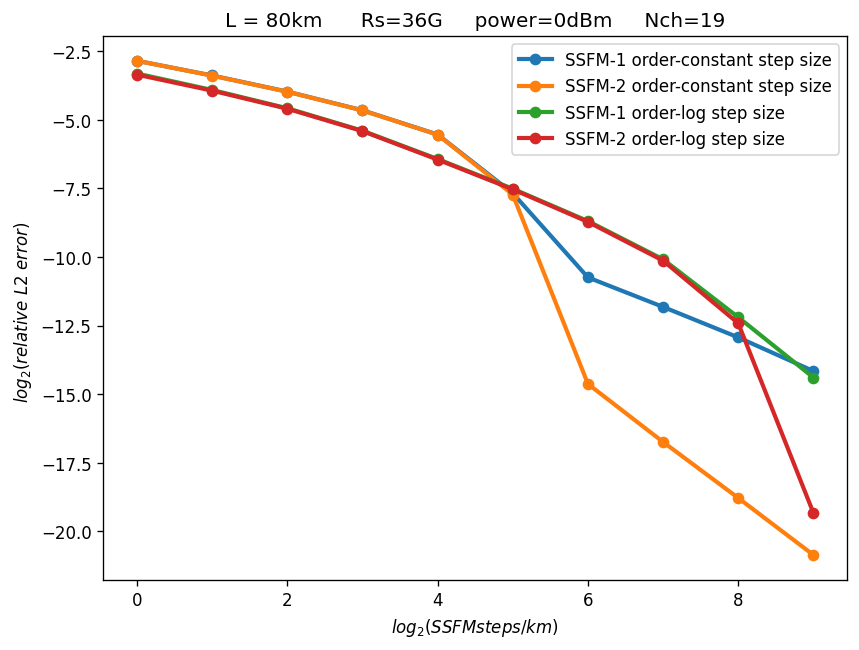

In [114]:
plt.figure(figsize=(8,6),dpi=120)
for k,lk in l.items():
    plt.plot(np.log2(Ns[0:-2]) - np.log2(80), np.log2(lk), '-o', label=k, linewidth=2.5)

plt.title(f'L = 80km      Rs={int(Rs/1e9)}G     power={p}dBm     Nch={Nch}')
plt.xlabel(r'$log_2(SSFM steps/km)$')
plt.ylabel(r'$log_2(relative \ L2 \ error)$  ')
plt.legend()

## Truncation error

In [18]:
def A(h):
    def _A(x):
        x = L(x, 0, h)
        x = NL(x, 0, h)
        return x
    return _A

def test_L(E, h):
    j_ifft = jnp.fft.ifft
    j_fft = jnp.fft.fft 
    n_ifft = np.fft.ifft
    n_fft = np.fft.fft
    return ifft(fft(x, axis=0), axis=0) - x

Sample rate fa: 1.152e+12, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (32768, 1), symb shape: (1024, 3, 1)
 Tx_data complete, time cost(s):2.353484630584717


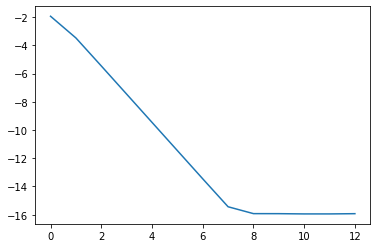

In [19]:
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1, Nmodes=1, Power=10, Nch=3, SpS=32, Nbits=int(np.log2(16))*1024, Rs=36e9, freq_space=50e9, M=16)
dz = [1000, 100, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8, 1e-9]  # [m]
Bound = []
for h in dz:
    A1 = A(h)
    A2 = A(2*h)
    Bound.append(L2(A1(A1(x)).val - A2(x).val))
    # Bound.append(L2( test_L(x,h) ))
    # Bound.append(L2( H1(h,x) - 1.0))

plt.plot(np.log10(Bound))

## 7.111 Manakov old vs new

In [ ]:
dz = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128]
p = 0
M = 16
Nch = 19
Rs = 190e9
freqspace = 220e9
sps = 32
sps_single = 2
chid = Nch//2
noise = False
amp = amp4 if noise else amp2
span_number = 1
span_length = 80e3
Nmodes = 2

F = partial(fiber, spans=span_number,span_length=span_length)
real_fiber = partial(F, module=partial(manakov2, H=H2,Leff=Leff2), amp=amp)
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=Nmodes, Power=p,Nch=Nch, SpS=sps, Nbits=int(np.log2(M))*10000, Rs=Rs, freq_space=freqspace, M=16)
symb = jax.device_get(symbWDM[:,chid,0])

y1 = []
for h in dz:
    y1.append(real_fiber(rd.PRNGKey(1), x, h*1000))


Sample rate fa: 6.08e+12, Cut off frequency fc: 2.09e+12, fa > 2fc: True
Transmitter is working..
signal shape: (320000, 2), symb shape: (10000, 19, 2)
 Tx_data complete, time cost(s):1.2446892261505127


In [ ]:
from optical_flax.utils import parameters

y2 = []
for h in dz:
    paramCh = parameters()
    paramCh.Ltotal = 80* 1 # km
    paramCh.Lspan  = 80     # km
    paramCh.alpha = 0.2    # dB/km
    paramCh.D = 16.5       # ps/nm/km
    paramCh.Fc = 299792458/1550E-9 # Hz
    paramCh.hz =  h     # km
    paramCh.gamma = 1.6567    # 1/(W.km)
    paramCh.amp = 'ideal'
    paramCh.NF = 4.5
    y2.append(manakov_ssf(rd.PRNGKey(1), x.val, x.Fs, paramCh))

## 7.00 EDFA

In [ ]:
span_length

80000.0

In [23]:
M = 16
chid = Nch//2
p = 6
pol = 0
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=1, Power=p,Nch=Nch, SpS=sps, Nbits=int(np.log2(M))*10000, Rs=190e9, freq_space=220e9, M=16)
symb = jax.device_get(symbWDM[:,chid,0])
x0 = rx(x, chid, sps_single)   # truth

z = x
for i in range(span_number):
    z = amp4(rd.PRNGKey(i), z, span_length,NF=4.5)
z = rx(z, chid, sps_single)

Sample rate fa: 6.08e+12, Cut off frequency fc: 2.09e+12, fa > 2fc: True
Transmitter is working..
signal shape: (320000, 1), symb shape: (10000, 19, 1)
 Tx_data complete, time cost(s):2.0024640560150146


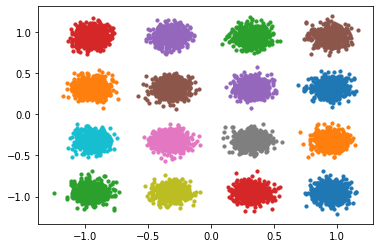

In [24]:
y1 = z.val[::sps_single,pol]
x1 = symb
y1 = y1/L2(y1)
show_symb(y1, x1)

In [ ]:
from optical_flax.fiber_tx import QAM
from commplax import comm
QAM(16).Es

DeviceArray(10., dtype=float64)

In [25]:
y1 = z.val[::sps_single,pol]
x1 = symb
y1 = y1/L2(y1)
comm.qamqot(y1, x1, scale=np.sqrt(10))

,BER,QSq,SNR
dim0,0.0,inf,20.006432
total,0.0,inf,20.006432


## 7.0 L  vs Lh

In [ ]:
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=2, Power=power,Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)
relative_L2(L(x, 0, 1e3, H2).val , Lh(x,0,1e3,61,h2).val)

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 2), symb shape: (256, 3, 2)
 Tx_data complete, time cost(s):1.2751915454864502


DeviceArray(6.02526183e-05, dtype=float64)

## 7.1 SSFM convergence

In [ ]:
dz = [80, 40, 20, 10, 5, 2.5]
M = 16
nch = 19
p = 3
Rs = 50e9
freqspace = 60e9
Nsymb = 100
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=1, Power=p,Nch=nch, SpS=sps, Nbits=int(np.log2(M))*Nsymb, Rs=Rs, freq_space=freqspace, M=M)


# Eo1,loss1 = test_convergence(x, partial(ssfm1,H=H1, Leff=Leff1), dz, span_length)
# Eo2,loss2 = test_convergence(x, partial(ssfm2,H=H1, Leff=Leff1), dz, span_length)
Eo3,loss3 = test_convergence(x, partial(ssfm1,H=H2, Leff=Leff2), dz, span_length)
Eo4,loss4 = test_convergence(x, partial(ssfm2,H=H2, Leff=Leff2), dz, span_length)


Sample rate fa: 1.6e+12, Cut off frequency fc: 5.7e+11, fa > 2fc: True
Transmitter is working..
signal shape: (3200, 1), symb shape: (100, 19, 1)
 Tx_data complete, time cost(s):1.8653287887573242


In [ ]:
def log_init(key, Nsamps):
    x = jnp.linspace(0,1,Nsamps)
    z = -1/alpha * jnp.log(1 - (1-jnp.exp(-alpha*span_length))*x)
    return z[1::] - z[0:-1]

def log_integral_points(key,Nsamps):
    x = jnp.linspace(0,1,Nsamps)
    return -1/alpha * jnp.log(1 - (1-jnp.exp(-alpha*span_length))*x)

dz = [log_init('key',100), log_init('key',200), log_init('key',400), log_init('key',800), log_init('key',1600), log_init('key',3200)]

Eo5,loss5 = test_convergence(x, partial(ssfm1,H=H2, Leff=Leff2), dz, span_length)
Eo6,loss6 = test_convergence(x, partial(ssfm2,H=H2, Leff=Leff2), dz, span_length)

Text(0.5, 1.0, 'ssfm loss')

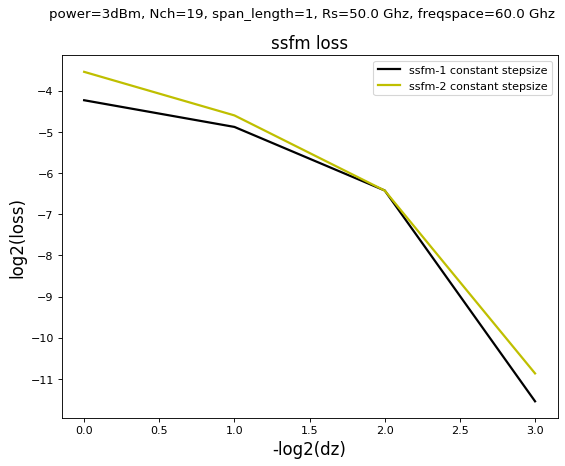

In [ ]:
plt.figure(figsize=(8,6), dpi=80)
plt.suptitle(f'power={p}dBm, Nch={nch}, span_length={1}, Rs={Rs/1e9} Ghz, freqspace={freqspace/1e9} Ghz')
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(loss3),label='ssfm-1 constant stepsize', linewidth=2, color='k')
plt.plot(np.log2(loss4),label='ssfm-2 constant stepsize', linewidth=2, color='y')
# plt.plot(np.log2(loss5),label='ssfm-1  Adaptive stepsize', linewidth=2, color='g')
# plt.plot(np.log2(loss6),label='ssfm-2  Adaptive stepsize', linewidth=2, color='b')
plt.legend()
plt.title('ssfm loss',size=15)


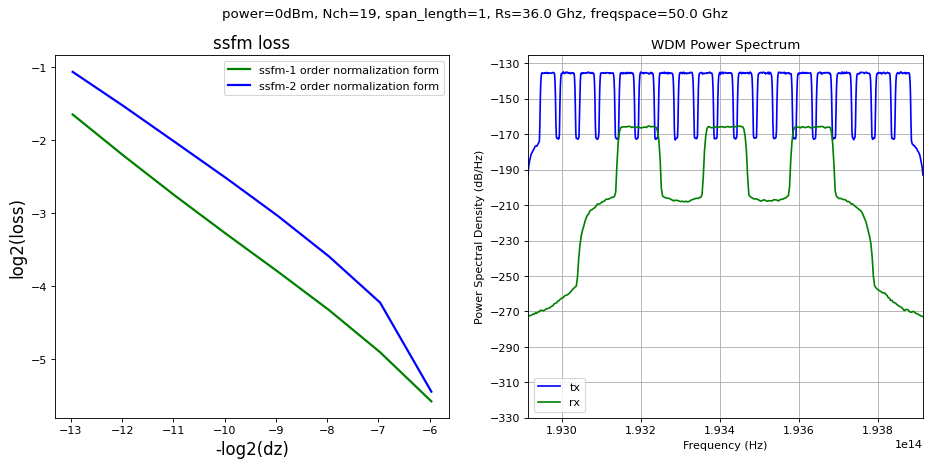

In [ ]:

print('Error of two scheme: nomalization or not: %g' % relative_L2(amp1('key', Eo2[-1],span_length).val, Eo4[-1].val))
plt.figure(figsize=(14,6), dpi=80)
plt.suptitle(f'power={p}dBm, Nch={nch}, span_length={1}, Rs={Rs/1e9} Ghz, freqspace={freqspace/1e9} Ghz')
plt.subplot(1,2,1)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(-np.log2(dz[0:-1]), np.log2(loss1),label='ssfm-1 order attenuation form', linewidth=2, color='y')
plt.plot(-np.log2(dz[0:-1]), np.log2(loss2),label='ssfm-2 order attenuation form', linewidth=2, color='k')
plt.plot(-np.log2(dz[0:-1]), np.log2(loss3),label='ssfm-1 order normalization form', linewidth=2, color='g')
plt.plot(-np.log2(dz[0:-1]), np.log2(loss4),label='ssfm-2 order normalization form', linewidth=2, color='b')
plt.legend()
plt.title('ssfm loss',size=15)


plt.subplot(1,2,2)
plt.psd(x.val[:,0], NFFT=4096//4, Fs=x.Fs, Fc=fc,sides='twosided',color='b', label='tx')
plt.psd(Eo2[-1].val[:,0], NFFT=4096//4, Fs=Eo2[-1].Fs, Fc=fc,sides='twosided',color='g', label='rx')
plt.legend()

plt.xlim([param.Fc - (nch+1)/2*freqspace, param.Fc + (nch+1)/2*freqspace])
plt.title('WDM Power Spectrum')
plt.xlabel('Frequency (Hz)')

def normalize(x):
    return x/L2(x)
print('distance of two scheme solution:',L2(normalize(Eo1[-1].val) - normalize(Eo3[-1].val)))

## 7.2 WDM-SSFM convergence

In [ ]:
M = 16
p = 10
nch = 3
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=1, Power=17,Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)
E = wdm_split(x, new_sps=4)
dz = [8e3, 4e3, 2e3, 1e3, 5e2, 250, 125, 62.5, 31.25]
y1,l1 = test_convergence(E, partial(wdm_ssfm1, H=WDM_H1, Leff=Leff1), dz, span_length)
y2,l2 = test_convergence(E, partial(wdm_ssfm2, H=WDM_H1, Leff=Leff1), dz, span_length)
y3,l3 = test_convergence(E, partial(wdm_ssfm1, H=WDM_H2, Leff=Leff2), dz, span_length)
y4,l4 = test_convergence(E, partial(wdm_ssfm2, H=WDM_H2, Leff=Leff2), dz, span_length)

Sample rate fa: 6.08e+12, Cut off frequency fc: 2.09e+12, fa > 2fc: True
Transmitter is working..
signal shape: (320000, 1), symb shape: (10000, 19, 1)
 Tx_data complete, time cost(s):1.8359222412109375


Error of two scheme: nomalization or not--- 0.38961933479657923


Text(0.5, 1.0, 'power=10dBm, Nch=3, span_length=1, Rs=190.0 Ghz, freqspace=220.0 Ghz')

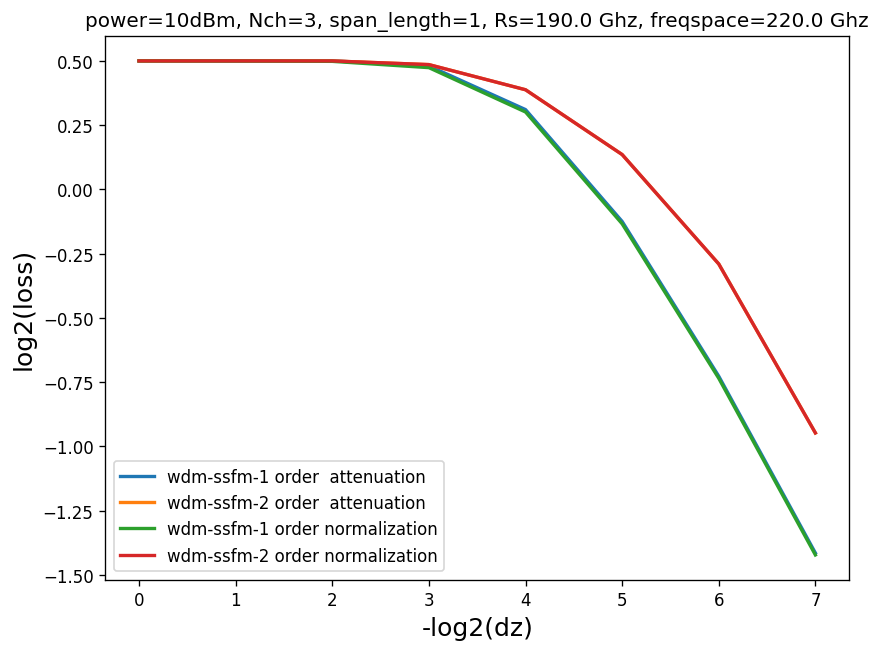

In [ ]:
print('Error of two scheme: nomalization or not---',relative_L2(amp1('key',y1[-1],span_length).val, y4[-1].val).item())

plt.figure(figsize=(8,6), dpi=120)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(l1),label='wdm-ssfm-1 order  attenuation', linewidth=2)
plt.plot(np.log2(l2),label='wdm-ssfm-2 order  attenuation', linewidth=2)
plt.plot(np.log2(l3),label='wdm-ssfm-1 order normalization', linewidth=2)
plt.plot(np.log2(l4),label='wdm-ssfm-2 order normalization', linewidth=2)
plt.legend()
plt.title(f'power={p}dBm, Nch={nch}, span_length={1}, Rs={Rs/1e9} Ghz, freqspace={freqspace/1e9} Ghz')

## 7.3 FWM noise

In [ ]:
p = 10
new_sps = 4
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1, Nmodes=1, Power=p, Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=10e9, freq_space=50e9)

dz = 50
Eo = ssfm2(x,span_length,dz,H=H2, Leff=Leff2)
ssfm_result = wdm_split(Eo, new_sps).val     # [Nfft, Nch, Nmodes]

Ei = wdm_split(x, new_sps)
wdm_ssfm_result = wdm_ssfm2(Ei,span_length,dz,WDM_H2, Leff2).val  # [Nfft, Nch, Nmodes]



Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):1.8349299430847168


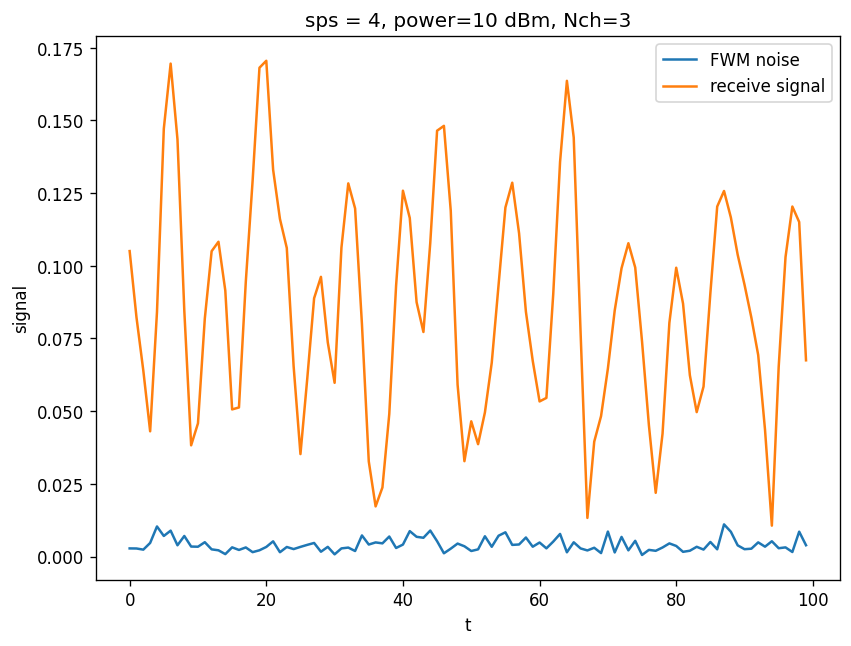

In [ ]:
chid = 1
pol = 0
s = 0
e = 100
plt.figure(figsize=(8,6),dpi=120)
plt.plot(jnp.abs(wdm_ssfm_result[s:e, chid, pol] - ssfm_result[s:e, chid, pol]), label='FWM noise')
plt.plot(jnp.abs(wdm_ssfm_result[s:e, chid, pol]), label='receive signal')
plt.xlabel('t')
plt.ylabel('signal')
plt.title(f'sps = {new_sps}, power={p} dBm, Nch={Nch}')
plt.legend()

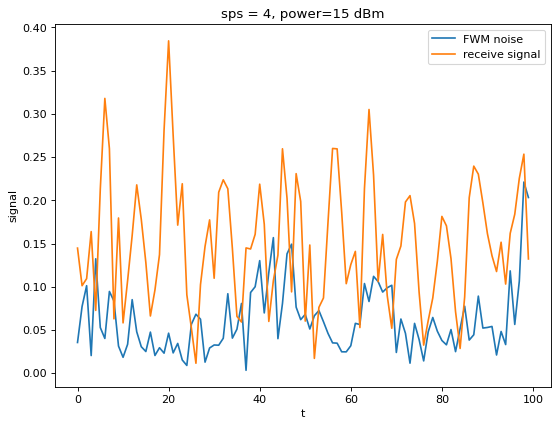

In [ ]:
chid = 1
pol = 0
s = 0
e = 100
plt.figure(figsize=(8,6),dpi=80)
plt.plot(jnp.abs(wdm_ssfm_result[s:e, chid, pol] - ssfm_result[s:e, chid, pol]), label='FWM noise')
plt.plot(jnp.abs(wdm_ssfm_result[s:e, chid, pol]), label='receive signal')
plt.xlabel('t')
plt.ylabel('signal')
plt.title(f'sps = {new_sps}, power={p} dBm')
plt.legend()

## 7.4 XPM noise

In [ ]:
def mask(E, chid):
    # E [Nfft, Nch, Nmodes]
    mask = jnp.zeros(Nch)
    mask = mask.at[chid].set(1)
    x = mask[None,:,None] * E.val
    return MySignal(val=x, sps=E.sps, Fs=E.Fs, Nch=E.Nch, freqspace=E.freqspace)

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):1.7582411766052246


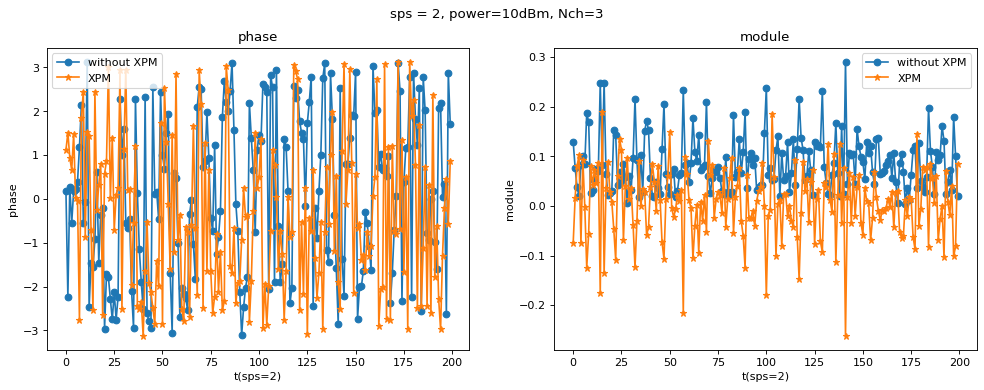

In [ ]:
p = 10
nch = 3
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=1, Power=p,Nch=nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)
chid = x.Nch//2
pol = 0
s = 100
e = 300

E = wdm_split(x, sps_single)
Es = mask(E, chid)
span_number = 10
ys = fiber(Es,dz=200,spans=span_number,span_length=span_length, module=partial(wdm_ssfm2, H=WDM_H2, Leff=Leff2))
y  = fiber(E,dz=200,spans=span_number,span_length=span_length, module=partial(wdm_ssfm2, H=WDM_H2, Leff=Leff2))

plt.figure(figsize=(15,5),dpi=80)

plt.suptitle(f'sps = {sps_single}, power={power}dBm, Nch={nch}')
plt.subplot(1,2,1)
plt.plot(jnp.angle(ys.val[s:e,chid, pol]),'-o',label='without XPM')
plt.plot(jnp.angle(y.val[s:e,chid, pol]/ys.val[s:e,chid, pol]),'-*', label='XPM')
plt.title('phase')
plt.xlabel('t(sps=2)')
plt.ylabel('phase')
plt.legend()

plt.subplot(1,2,2)
plt.plot(jnp.abs(ys.val[s:e,chid, pol]),'-o',label='without XPM')
plt.plot(jnp.abs(y.val[s:e,chid, pol]) - jnp.abs(ys.val[s:e,chid, pol]) ,'-*',label='XPM')
plt.title('module')
plt.xlabel('t(sps=2)')
plt.ylabel('module')
plt.legend()

## 7.5 Manakov convergence

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 2), symb shape: (256, 3, 2)
 Tx_data complete, time cost(s):1.7517931461334229


Text(0.5, 1.0, 'cssfm loss')

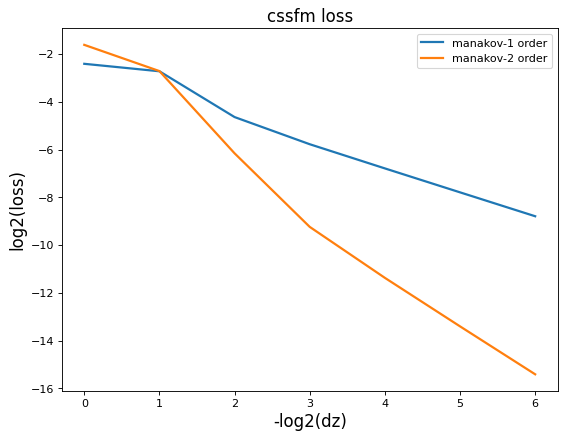

In [ ]:
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=2, Power=power,Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)

dz = [8e3, 4e3, 2e3, 1e3, 5e2, 250, 125, 62.5]
y1,l1 = test_convergence(x, manakov1, dz, 80e3)
y2,l2 = test_convergence(x, manakov2, dz, 80e3)

plt.figure(figsize=(8,6), dpi=80)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(l1),label='manakov-1 order', linewidth=2)
plt.plot(np.log2(l2),label='manakov-2 order', linewidth=2)
plt.legend()
plt.title('cssfm loss',size=15)

## 7.6 WDM-Manakov convergence

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 2), symb shape: (256, 3, 2)
 Tx_data complete, time cost(s):1.349694013595581


Text(0.5, 1.0, 'wdm-manakov loss')

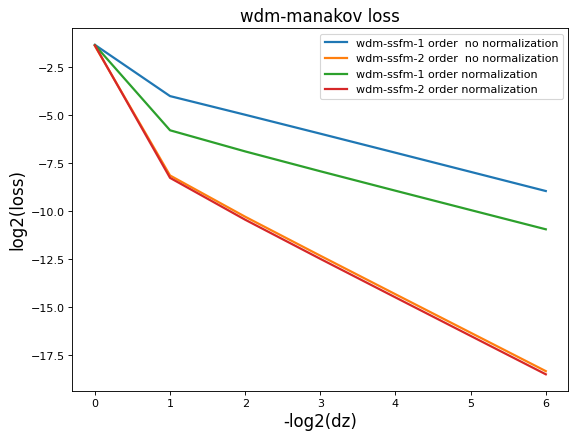

In [ ]:
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=2, Power=power,Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)

Ed = wdm_split(x, new_sps=sps_single)

dz = [8e3, 4e3, 2e3, 1e3, 5e2, 250, 125, 62.5]
y1,l1 = test_convergence(Ed, partial(wdm_manakov1, H=WDM_H1, Leff=Leff1), dz, span_length)
y2,l2 = test_convergence(Ed, partial(wdm_manakov2, H=WDM_H1, Leff=Leff1), dz, span_length)
y3,l3 = test_convergence(Ed, partial(wdm_manakov1, H=WDM_H2, Leff=Leff2), dz, span_length)
y4,l4 = test_convergence(Ed, partial(wdm_manakov2, H=WDM_H2, Leff=Leff2), dz, span_length)

plt.figure(figsize=(8,6), dpi=80)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(l1),label='wdm-ssfm-1 order  no normalization', linewidth=2)
plt.plot(np.log2(l2),label='wdm-ssfm-2 order  no normalization', linewidth=2)
plt.plot(np.log2(l3),label='wdm-ssfm-1 order normalization', linewidth=2)
plt.plot(np.log2(l4),label='wdm-ssfm-2 order normalization', linewidth=2)
plt.legend()
plt.title('wdm-manakov loss',size=15)

## 7.7 Nonlinear polarization cross talk

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 2), symb shape: (256, 3, 2)
 Tx_data complete, time cost(s):1.81312894821167


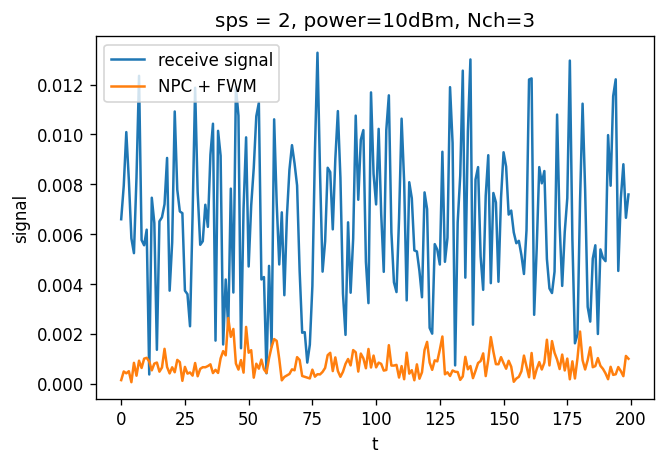

In [ ]:
# WDM-Manakov:  SPM, XPM
p = 10
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=2, Power=p,Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)
Ed = wdm_split(x, new_sps=sps_single)  # 分通道信号  [Nfft, Nch, Nmodes]
y0 = wdm_manakov1(Ed, span_length, dz=100)

# Manakov: SPM, XPM, FWM, NPC
y_wdm = manakov1(x, span_length, dz=100)
y_true = wdm_split(y_wdm,new_sps=sps_single)

s = 0
e = 200
pol = 0
chid = Nch//2

plt.figure(figsize=(6,4),dpi=120)
plt.plot(jnp.abs(y_true.val[s:e,chid,pol]), label='receive signal')
plt.plot(jnp.abs(y0.val[s:e,chid,pol] - y_true.val[s:e,chid,pol]), label='NPC + FWM')
plt.xlabel('t')
plt.ylabel('signal')
plt.title(f'sps = {sps_single}, power={p}dBm, Nch={nch}')
plt.legend()

## 7.8 pertubation convergence

In [17]:
def log_integral_points(Nsamps):
    x = jnp.linspace(0,1,Nsamps)
    return -1/alpha * jnp.log(1 - (1-jnp.exp(-alpha*span_length))*x)

def square_integral_points(Nsamps):
    a = -1 
    x = jnp.linspace(0,1,Nsamps)
    return span_length * (-a*x**2 + (1+a)*x)

In [29]:
new_power = -10
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=1, Power=new_power,Nch=3, SpS=sps, Nbits=4*1000, Rs=36e9, freq_space=50e9)

# psi,v_cutlp = CutLP(x, 80e3, 4, integral_points)
# cutu,v_cutrp = CutRP(x, 80e3, 8, integral_points)   
# v_lp = LP_solver(x, 80e3, 8, integral_points)
points = [10,20,40,80,160, 320, 640, 1280]
order = 12
v_rp = {}
l = {}
for p in points:
    xi = jnp.linspace(0, span_length, p)
    # xi = log_integral_points(p)
    # xi = square_integral_points(p)
    v = RP_solver(x, xi, order)
    # v = CutRP(x, span_length, 8, integral_points=p)[1]
    v_rp[f'number of integral points = {p}'] = v

    
v_true = ssfm2(x, span_length,dz=10,H=H2,Leff=Leff2)
for p,v in v_rp.items():
    l[p] = []
    for i in range(order+1):
        l[p].append(relative_L2(v[i].val[-1], v_true.val))


plt.figure(figsize=(8,6),dpi=100)
plt.xlabel('pertubation order', size=15)
plt.ylabel('log2(relative error)',size=15)
plt.title(f'RP power = {new_power} dBm    Nch = {Nch}   distance = {span_length/1e3} km')
for k,lc in l.items():
    plt.plot(np.log2(lc), label=k)
plt.legend()


Sample rate fa: 1.152e+12, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (32000, 1), symb shape: (1000, 3, 1)
 Tx_data complete, time cost(s):1.307969331741333


: 

: 

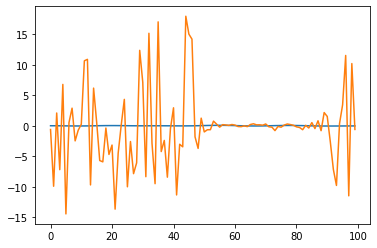

In [27]:
y = v_rp['number of integral points = 10'][-1].val[-1]
plt.plot(y[0:100].real)
plt.plot(v_true.val[0:100].real - y[0:100].real)

## 7.9 BRP convergence

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):1.2552220821380615


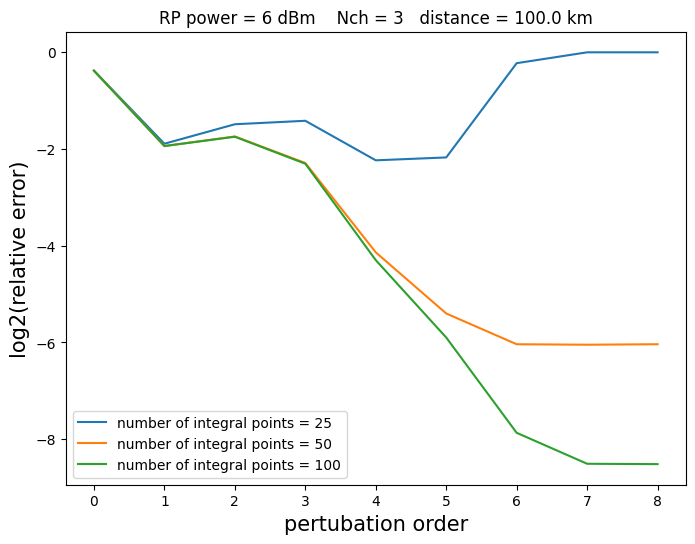

In [ ]:
new_power = 6
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1 , Nmodes=1, Power=new_power,Nch=Nch, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace)
v_true = ssfm2(x, span_length,dz=100,H=H2,Leff=Leff2)
# v0 = rx(v_true, Nch//2, sps)
v0 = v_true

points = [25,50,100]

v_rp = {}
l = {}
for p in points:
    v = BRP1_solver(v0, span_length, 8, integral_points=p)
    v_rp[f'number of integral points = {p}'] = v
for p,v in v_rp.items():
    l[p] = []
    for i in range(9):
        l[p].append(relative_L2(v[i].val[-1], x.val))

plt.figure(figsize=(8,6),dpi=100)
plt.xlabel('pertubation order', size=15)
plt.ylabel('log2(relative error)',size=15)
plt.title(f'RP power = {new_power} dBm    Nch = {Nch}   distance = {span_length/1e3} km')
for k,lc in l.items():
    plt.plot(np.log2(lc), label=k)
plt.legend()
    

## 7.9 LP fail convergence ???

In [ ]:
u,v = CutRP(x,80e3 ,4, 20)
p1 = save_divide(u[1], u[0], 1)
p2 = save_divide(u[2], u[0], 2) - 1/2*p1**2
p3 = save_divide(u[3], u[0], 3) - p1*p2 - 1/6*p1**3
p4 = save_divide(u[4], u[0], 4) - p1*p3 - 1/2*p2**2 - 1/2*p1**2*p2 - 1/24*p1**4

psi = [p1,p2,p3,p4]
v = []
v.append(u[0])
for i in range(1,4+1):
    v.append(v[-1]*jnp.exp(gamma**i*psi[i-1])) 

up = []
for i in range(5):
    up.append(u[i][-1][442].item())

p1 = up[1]/up[0]
p2 = up[2]/up[0] - 1/2*p1**2
p3 = up[3]/up[0]- p1*p2 - 1/6*p1**3
p4 = up[4]/up[0] - p1*p3 - 1/2*p2**2 - 1/2*p1**2*p2 - 1/24*p1**4

## 7.10 CDC, FDBP, SDBP

In [ ]:
# # 生成数据
# dz = 0.032  # [km]
# Nsymb = 10000
# p = 0
# M = 16
# Nch = 19
# Rs = 36e9
# freqspace = 50e9
# sps = 32
# sps_single = 2
# chid = Nch//2
# noise = False
# amp = amp4 if noise else amp1
# span_number = 25
# span_length = 80e3
# Nmodes = 1

# config.update("jax_enable_x64", True)

# x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1, Nmodes=Nmodes, Power=p,Nch=Nch, SpS=sps, Nbits=int(np.log2(M))*Nsymb, Rs=Rs, freq_space=freqspace, M=M)
# symb = jax.device_get(symbWDM[:,chid,0])
# symbWDM = 0

# # Old SSFM
# from optical_flax.utils import parameters
# paramCh = parameters()
# paramCh.Ltotal = span_length/1e3 * span_number  # km
# paramCh.Lspan  = span_length/1e3      # km
# paramCh.alpha = 0.2        # dB/km
# paramCh.D = 16.5         # ps/nm/km
# paramCh.Fc = 299792458/1550E-9 # Hz
# paramCh.hz =  h          # km
# paramCh.gamma = 1.6567   # 1/(W.km)
# paramCh.amp = 'ideal'
# paramCh.NF = 4.5
# y = ssfm(rd.PRNGKey(1), x.val, x.Fs, paramCh,order=1)


In [15]:
path =  '/home/xiaoxinyu/data/0912train_dz_2m'
p = 3.0
path_tx = path + f'/Tx_ch19_power{p}'
path_rx = path + f'/Channel_ch19_power{p}_dz0.002'

In [25]:
path = '/home/xiaoxinyu/data/0908train_190G'     #
p = 6
path_tx = path + f'/Tx_ch19_power{p}'
path_rx = path + f'/Channel_ch19_power{p}'      

In [22]:
path =  '/home/xiaoxinyu/data/0912train_36G_dz32m'
p = 3.0
path_tx = path + f'/Tx_ch19_power{p}'
path_rx = path + f'/Channel_ch19_power{p}_dz0.032'

In [46]:
x_batch, symbWDM, param = pickle.load(open(path_tx, 'rb'))
y_batch, paramCh = pickle.load(open(path_rx, 'rb'))

x = MySignal(val=jax.device_put(x_batch[0]), sps=param.SpS, Fs=param.Rs*param.SpS, Nch=param.Nch, freqspace=param.freqSpac)
y = MySignal(val=jax.device_put(y_batch[0,:,None]), sps=param.SpS, Fs=param.Rs*param.SpS, Nch=param.Nch, freqspace=param.freqSpac)
symb = symbWDM[0,:,Nch//2,0]

chid = Nch // 2
x0 = rx(x, chid, sps_single)   # truth
y0 = rx(y, chid, sps_single)   # Input



F = partial(fiber, spans=span_number,span_length=span_length)
dbp  = partial(F, module=DBP, amp=amp2)
cdc1 = partial(F, module=CDC1, amp=amp2)
cdc2 = partial(F, module=partial(CDC2, dtaps=2001), amp=amp2)

dbp_dz = 1000   # [m]

# FDBP
x_fdbp0 = dbp(rd.PRNGKey(2), y, dz=dbp_dz)
x_fdbp = rx(x_fdbp0, chid, sps_single)


# SDBP
x_sdbp = dbp(rd.PRNGKey(2), y0, dz=dbp_dz)

# CDC
x_cdc1 = cdc1(rd.PRNGKey(2), y0,dz=span_length)
x_cdc2 = cdc2(rd.PRNGKey(2), y0,dz=span_length)

print('MSE of two cdc ways: ', MSE(x_cdc1.val,x_cdc2.val)/MSE(x_cdc1.val,0))
z_fdbp = x_fdbp.val[0::sps_single, :]
z_fdbp = z_fdbp / L2(z_fdbp)

z_sdbp = x_sdbp.val[0::sps_single, :] 
z_sdbp = z_sdbp / L2(z_sdbp)

z_cdc = x_cdc1.val[0::sps_single, :]
z_cdc = z_cdc / L2(z_cdc)

z_nocomp = y0.val[0::sps_single, :]
z_nocomp = z_nocomp / L2(z_nocomp)


MSE of two cdc ways:  9.62172481769551e-10


0.01006


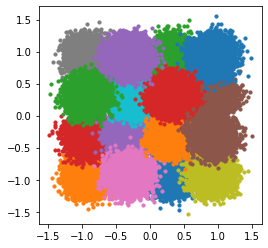

In [51]:
from optical_flax.dsp import bps
def BPS(z, symbTx, pilotInd=np.arange(100, dtype=int),  N=51, B=31):
    mod = QAM(16)
    constSymb = mod.constellation / jnp.sqrt(mod.Es)
    theta = bps(jax.device_get(z_cdc), N, jax.device_get(constSymb), B)
    theta = np.unwrap(4 * theta, axis=0) / 4
    y1 = z_cdc*jnp.exp(1j*theta)*jnp.exp(1j*2*np.pi/2)

    plt.figure(figsize=(4,4))
    show_symb(y1,symb)

    res = comm.qamqot(y1[:,0], symb, scale=np.sqrt(10))
    ber = res['BER']['dim0']
    print(ber)

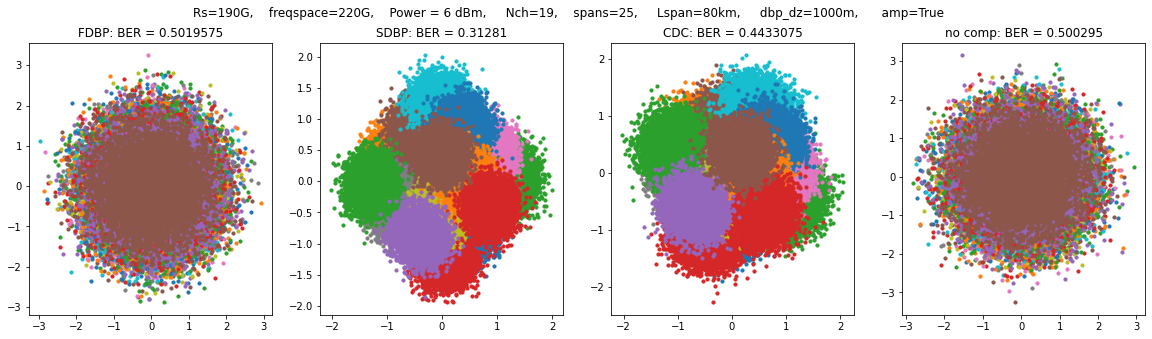

In [27]:
## 星座图
plt.figure(figsize=(20,5))
dz = paramCh.hz
noise = True
plt.suptitle(f'Rs={int(param.Rs//1e9)}G,    freqspace={int(param.freqSpac/1e9)}G,    Power = {p} dBm,     Nch={param.Nch},    spans={paramCh.Ltotal // paramCh.Lspan},     Lspan={paramCh.Lspan}km,     dbp_dz={dbp_dz}m,      amp={noise}')


z = [z_fdbp, z_sdbp, z_cdc, z_nocomp]
names = ['FDBP', 'SDBP', 'CDC', 'no comp']

for i in range(len(z)):
    plt.subplot(1,len(z),i+1)
    show_symb(z[i],symb)
    res = comm.qamqot(z[i], symb, scale=np.sqrt(10))
    ber = res['BER']['dim0']
    plt.title(names[i] + f': BER = {ber}' )



In [105]:
y1 = z_sdbp / L2(z_sdbp)
comm.qamqot(y1, symb, scale=np.sqrt(10))

,BER,QSq,SNR
dim0,0.003705,8.555672,15.375678
total,0.003705,8.555672,15.375678


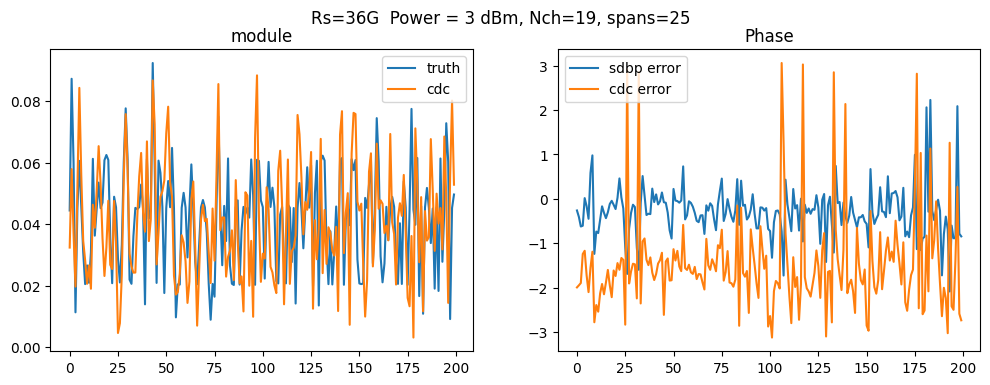

In [87]:
## 模长，相位误差
plt.figure(figsize=(12,4),dpi=100)
plt.suptitle(f'Rs={int(Rs/1e9)}G  Power = {power} dBm, Nch={Nch}, spans={span_number}')
s = 1800
e = 2000
pol = 0
plt.subplot(1,2,1)

# plt.plot(jnp.abs(x_sdbp.val[s:e,pol]), label='sdbp')
plt.plot(jnp.abs(x0.val[s:e,pol]), label='truth')
plt.plot(jnp.abs(x_cdc1.val[s:e,pol]), label='cdc')
plt.title('module')
plt.legend()

plt.subplot(1,2,2)
plt.plot(jnp.angle(x_sdbp.val[s:e,pol]/x0.val[s:e,pol]), label='sdbp error')
plt.plot(jnp.angle(x_cdc1.val[s:e,pol]/x0.val[s:e,pol] * jnp.exp(1.9j)), label='cdc error')
# plt.plot(jnp.angle(x0.val[s:e,pol]),label='truth')
plt.title('Phase')
plt.legend()

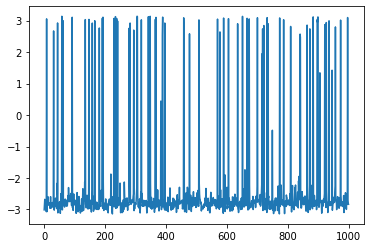

In [ ]:
plt.plot(jnp.angle(x_cdc1.val/x0.val)[1000:2000])

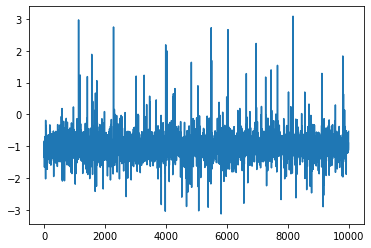

In [ ]:
plt.plot(jnp.angle(x_sdbp.val/x0.val)[10000:20000])

**结论： 信息传输速率的增加会使得XPM noise变简单 ！！！！**

## 7.11 data generation   train data    test data

In [ ]:
# generate data
data_list = data_generation(rd.PRNGKey(2146), train_num=10000,batch_num=10
,dz=200, chid=3//2,  span_length=100e3, span_number=1, power=10, Nch=3,
 Nmodes=1, sps=16, Nsymb=256, Rs=10e9, freqspace=50e9, equation='NLSE', M=16)

# merge data
data_dict = data_merge(data_list)

# save data
path = f'/home/xiaoxinyu/data/0823train_toy/data_nlse_power{power}'
pickle.dump(data_dict, open(path ,'wb'))

generate data: 100%|██████████| 10/10 [01:57<00:00, 11.76s/it]


In [ ]:
# generate data
data_list = data_generation(rd.PRNGKey(321), train_num=1000, batch_num=1)

# merge data
data_dict = data_merge(data_list)

# save data
path = f'/home/xiaoxinyu/data/0823test_toy/data_power{power}'
pickle.dump(data_dict, open(path ,'wb'))

generate data: 100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


In [ ]:
# generate data
data_list = data_generation(rd.PRNGKey(2146), train_num=1000,batch_num=2
,dz=200, chid=3//2,  span_length=100e3, span_number=1, power=10, Nch=3,
 Nmodes=1, sps=16, Nsymb=256, Rs=10e9, freqspace=50e9, equation='WDM-NLSE', M=16)

# merge data
data_dict = data_merge(data_list)

# save data
path = f'/home/xiaoxinyu/data/0823train_toy/data_wdm_nlse_power{power}'
pickle.dump(data_dict, open(path ,'wb'))

In [ ]:
# generate data
data_list = data_generation(rd.PRNGKey(2146), data_num=10000,batch_num=10
,dz=10, chid=3//2,  span_length=80e3, span_number=25, power=0, Nch=19,
 Nmodes=1, sps=32, Nsymb=10000, Rs=190e9, freqspace=220e9, equation='NLSE', M=16)

# merge data
data_dict = data_merge(data_list)

# save data
path = f'/home/xiaoxinyu/data/0907train_Huawei/data_nlse_power{power}'
pickle.dump(data_dict, open(path ,'wb'))

In [ ]:
# generate data
data_list = data_generation(rd.PRNGKey(2112), data_num=10000,batch_num=10
,dz=10, chid=3//2,  span_length=80e3, span_number=25, power=0, Nch=19,
 Nmodes=1, sps=32, Nsymb=10000, Rs=190e9, freqspace=220e9, equation='NLSE', M=16)

# merge data
data_dict = data_merge(data_list)

# save data
path = f'/home/xiaoxinyu/data/0907test_Huawei/data_nlse_power{power}'
pickle.dump(data_dict, open(path ,'wb'))

## 7.11 LDBP: Training

In [ ]:
# load data
path = f'/home/xiaoxinyu/data/0823train_toy/data_power{power}'
data_dict = pickle.load(open(path, 'rb'))
# data loader
data = partial(data_loader, data_dict, new_sps=8, batch=100,rng=rd.PRNGKey(21))
# 输入样例
for i, (x0,y0,symb0) in enumerate(data()):
    break

net_nn = realize(LDBP(length=span_length*span_number, steps=10, nn_mode=True))
tx = optax.adam(learning_rate=0.01)

update_step = construct_update(net_nn, tx)
param = net_nn.init(rd.PRNGKey(123), x0)
opt_state = tx.init(param)
param, opt_state, l_list = train(update_step, param, opt_state, data,epochs=20)

epoch 0 iter 0: loss 0.0173614 
epoch 0 iter 20: loss 0.00133418 
epoch 0 iter 40: loss 0.00105198 
epoch 0 iter 60: loss 0.000921851 
epoch 0 iter 80: loss 0.000885082 
epoch 1 iter 0: loss 0.000884325 
epoch 1 iter 20: loss 0.000851323 
epoch 1 iter 40: loss 0.000853779 
epoch 1 iter 60: loss 0.000818286 
epoch 1 iter 80: loss 0.000826161 
epoch 2 iter 0: loss 0.000836064 
epoch 2 iter 20: loss 0.000806373 
epoch 2 iter 40: loss 0.000815645 
epoch 2 iter 60: loss 0.000778232 
epoch 2 iter 80: loss 0.000789141 
epoch 3 iter 0: loss 0.000800893 
epoch 3 iter 20: loss 0.000774186 
epoch 3 iter 40: loss 0.000787605 
epoch 3 iter 60: loss 0.000751088 
epoch 3 iter 80: loss 0.000760666 
epoch 4 iter 0: loss 0.000771809 
epoch 4 iter 20: loss 0.000748542 
epoch 4 iter 40: loss 0.000760728 
epoch 4 iter 60: loss 0.000721068 
epoch 4 iter 80: loss 0.000727942 
epoch 5 iter 0: loss 0.000737131 
epoch 5 iter 20: loss 0.00071404 
epoch 5 iter 40: loss 0.000732837 
epoch 5 iter 60: loss 0.0006864

In [ ]:
net_meta = realize(LDBP(length=span_length*span_number, steps=10, nn_mode=False))
tx = optax.adam(learning_rate=0.001)

update_step = construct_update(net_meta, tx)
param = net_meta.init(rd.PRNGKey(123), x0)
opt_state = tx.init(param)
param, opt_state, l_list = train(update_step, param, opt_state, data,epochs=20)

## 7.12  LDBP:Testing

In [ ]:
# load data
path = f'/home/xiaoxinyu/data/0823test_toy/data_power{power}'
data_dict = pickle.load(open(path, 'rb'))
# data loader
data = data_loader(data_dict, new_sps=8, batch=1, rng=rd.PRNGKey(231))
# 输入样例
for i, (x_test,y_test,symb_test) in enumerate(data):
    break
symb_test = symb_test[0,:,0]

F = partial(fiber, spans=span_number,span_length=span_length)
real_fiber = partial(F, module=partial(ssfm2, H=H2,Leff=Leff2))
dbp  = partial(F, module=DBP, dz=100)
cdc1 = partial(F, module=CDC1, dz=span_length)

# SDBP
x_sdbp = jax.vmap(dbp)(x_test)

# CDC
x_cdc = jax.vmap(cdc1)(x_test)

# LDBP
x_ldbp = net_nn.apply(param, x_test)

Text(0.5, 1.0, 'no comp')

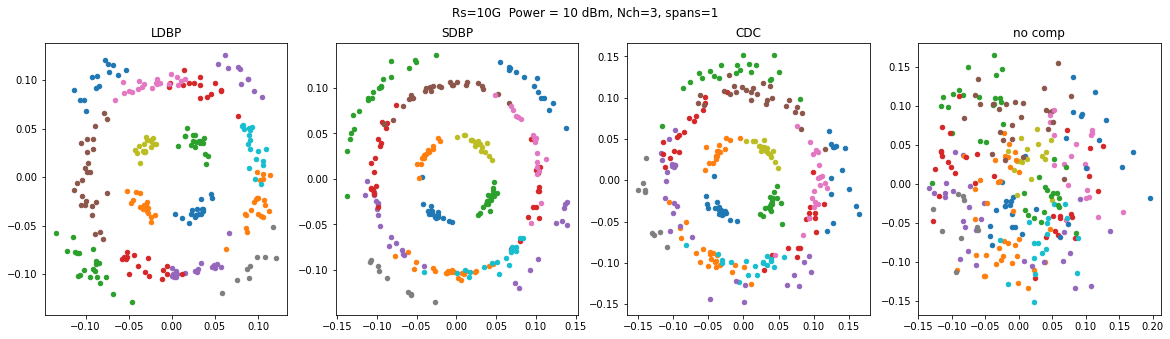

In [ ]:
## 星座图
plt.figure(figsize=(20,5))
plt.suptitle(f'Rs={int(Rs/1e9)}G  Power = {power} dBm, Nch={Nch}, spans={span_number}')

pol = 0
symb = jax.device_get(symb_test)
new_sps = x_test.sps
plt.subplot(1,4,1)
z = x_ldbp.val[0,0::new_sps, pol]
show_symb(z,symb, s=20)
plt.title('LDBP')

plt.subplot(1,4,2)
z = x_sdbp.val[0,0::new_sps, pol]
show_symb(z,symb, s=20)
plt.title('SDBP')

plt.subplot(1,4,3)
z = x_cdc.val[0,0::new_sps, pol]
show_symb(z,symb,s=20)
plt.title('CDC')

plt.subplot(1,4,4)
z = x_test.val[0, 0::new_sps, pol]
show_symb(z,symb, s=20)
plt.title('no comp')


## 7.13 Long sequence learning

In [ ]:
path = '/home/xiaoxinyu/data/0912train_dz_2m'
p = 0.0
path_tx = path + f'/Tx_ch19_power{p}'
path_rx = path + f'/Channel_ch19_power{p}_dz0.002'
x_batch, symbWDM, param = pickle.load(open(path_tx, 'rb'))
y_batch, paramCh = pickle.load(open(path_rx, 'rb'))

x = MySignal(val=jax.device_put(x_batch[0:1]), sps=param.SpS, Fs=param.Rs*param.SpS, Nch=param.Nch, freqspace=param.freqSpac)
y = MySignal(val=jax.device_put(y_batch[0:1,:,None]), sps=param.SpS, Fs=param.Rs*param.SpS, Nch=param.Nch, freqspace=param.freqSpac)
symb = symbWDM[0,:,Nch//2,0]

chid = Nch//2
x0 = rx(x, chid, sps_single)   # truth
y0 = rx(y, chid, sps_single)   # Input

In [ ]:
# net_nn = realize(LDBP(length=span_length*span_number, steps=10, nn_mode=True))
net_nn = rotation()
tx = optax.adam(learning_rate=0.1)

update_step = construct_update(net_nn, tx)
param = net_nn.init(rd.PRNGKey(123), y0)
opt_state = tx.init(param)

In [ ]:
for i in range(200):
    param,opt_state,l = update_step(param,opt_state, y0, x0)
    if i % 1 == 0:
        print(f'epoch {i}: {l.item()}')

epoch 0: 0.038874366421807104
epoch 1: 0.03887373971830428
epoch 2: 0.038873111757703055
epoch 3: 0.03887248894142649
epoch 4: 0.03887187779018573
epoch 5: 0.038871284857982566
epoch 6: 0.03887071661974804
epoch 7: 0.03887017933193695
epoch 8: 0.03886967886686665
epoch 9: 0.03886922052374919
epoch 10: 0.038868808822356174
epoch 11: 0.038868447289111006
epoch 12: 0.038868138249955275
epoch 13: 0.03886788264907161
epoch 14: 0.038867679916485445
epoch 15: 0.038867527909251555
epoch 16: 0.03886742294864363
epoch 17: 0.03886735996810552
epoch 18: 0.03886733277345225
epoch 19: 0.03886733439963596
epoch 20: 0.03886735753110545
epoch 21: 0.038867394940296326
epoch 22: 0.038867439895186894
epoch 23: 0.03886748649349069
epoch 24: 0.038867529895772156
epoch 25: 0.038867566447901056
epoch 26: 0.03886759369974093
epoch 27: 0.03886761033831331
epoch 28: 0.03886761605882861
epoch 29: 0.03886761139689595
epoch 30: 0.03886759754189388
epoch 31: 0.03886757614689496
epoch 32: 0.03886754914612427
epoch 33

In [ ]:
param

FrozenDict({
    params: {
        theta: DeviceArray([2.6889227], dtype=float64),
    },
})

# 8.卷积转化

In [ ]:
from optical_flax.operator import circFilter
net = nn.Conv(features=1,kernel_size=(3,),strides=(1,),padding='CIRCULAR')
x = rd.normal(rd.PRNGKey(0),(10,1))
y,p = net.init_with_output(rd.PRNGKey(0), x)
x = jnp.squeeze(x)
h = jnp.squeeze(p['params']['kernel'])
circFilter(jnp.flip(h),x) - jnp.squeeze(y)

DeviceArray([-1.59971695e-07,  1.92412726e-08,  2.26221607e-08,
             -8.52863424e-09,  6.80817607e-08, -1.17440908e-07,
              1.21901792e-07,  1.19220423e-07, -5.84434207e-08,
             -6.11624786e-08], dtype=float64)

In [ ]:
from optical_flax.operator import circFilter
net = nn.Conv(features=2,kernel_size=(3,),strides=(1,),padding='CIRCULAR')
x = rd.normal(rd.PRNGKey(0),(10,5))
y,p = net.init_with_output(rd.PRNGKey(0), x)
p['params']['kernel'].shape   # [kernel_size, Ci, Co]

(3, 5, 2)

# 9.色散卷积算子的实现

compare two linear operator: 4.1107638761563226e-05


Text(0, 0.5, 'h0')

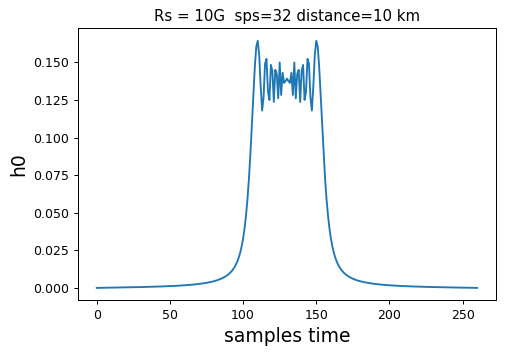

In [ ]:
test = rd.normal(rd.PRNGKey(0),(160000,), dtype='complex')


def DBP_H2(dz, Nfft):
    '''
    DBP split form 1: normalization
    kernel: frequency domain
    '''
    omega = 2*np.pi * Fs_single * fftfreq(Nfft)*10
    return jnp.exp(-1j * (beta2/2) * (omega**2) * dz)

def DBP_h2(dz, dtaps):
    '''
    DBP split form 1: normalization
    kernel: time domain
    '''
    return fftshift(ifft(DBP_H2(dz, dtaps)))


def MSE(x,y):
    return jnp.mean(jnp.abs(x-y)**2)

h0 = DBP_h2(-10e3,261)
y1 = ifft(fft(test)*DBP_H2(-10e3, test.shape[0]))
y2 = circFilter(h0, test)
print('compare two linear operator:',MSE(y1,y2))

plt.figure(figsize=(6,4),dpi=90)
plt.plot(jnp.abs(h0))
plt.title(f'Rs = {10}G  sps={sps} distance={10} km')
plt.xlabel('samples time',size=15)
plt.ylabel('h0',size=15)

In [ ]:
def disp_init(key, xi, dtaps):
    k = jax.vmap(DBP_h2,in_axes=(0,None),out_axes=-1)(xi,dtaps)
    return k[:,None,:]  # [dtaps,1,Co]


In [ ]:
disp_init('key',jnp.arange(10),261).shape

(261, 1, 10)

In [ ]:
x0

MySignal(val=DeviceArray([[ 0.01738684-0.02721859j],
             [-0.00531164-0.02673227j],
             [-0.03063149-0.01123174j],
             ...,
             [ 0.01118948-0.0016605j ],
             [ 0.00607618-0.01030483j],
             [ 0.01389597-0.01829895j]], dtype=complex128), Fs=380000000000.0, sps=2, Nch=19, freqspace=220000000000.0)

In [ ]:
x0.val.shape

(200000, 1)

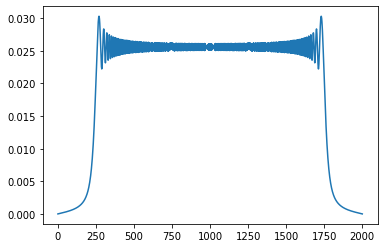

In [ ]:
plt.plot(jnp.abs(h2(80e3, x0, 2001)))

## BPS

In [290]:
from optical_flax.dsp import cpr, bps, ddpll

M = 16
mod = QAM(16)
constSymb = mod.constellation / jnp.sqrt(mod.Es)
x, symbWDM, param = Tx_signal(rd.PRNGKey(0), 1, Nmodes=1, Power=power,Nch=Nch, SpS=sps, Nbits=int(np.log2(M))*10000, Rs=Rs, freq_space=freqspace, M=16)

truth = jax.device_get(symbWDM[:,0,:])
n1 = rd.normal(rd.PRNGKey(0), truth.shape, dtype=jnp.float64)*0.05
n2 = rd.normal(rd.PRNGKey(1), truth.shape, dtype=jnp.complex128)*0.1
pn = jnp.cumsum(n1, axis=0)

y = truth * jnp.exp(1j*pn) + n2


Sample rate fa: 6.08e+12, Cut off frequency fc: 2.09e+12, fa > 2fc: True
Transmitter is working..
signal shape: (320000, 1), symb shape: (10000, 19, 1)
 Tx_data complete, time cost(s):1.7773034572601318


In [291]:
## BPS
theta0 = bps(jax.device_get(y), 11, jax.device_get(constSymb), 101)
theta1 = np.unwrap(4 * theta0, axis=0) / 4
y1 = y*jnp.exp(1j*theta1)

## DDPLL
tau1 = 1 / (2 * np.pi * 10e6)
tau2 = 1 / (2 * np.pi * 10e6)
theta = ddpll(jax.device_get(y), 1/Rs, 0.5, tau1, tau2, jax.device_get(constSymb), truth, np.arange(100,dtype=int))
theta2 = np.unwrap(4 * theta, axis=0) / 4
y2 = y*jnp.exp(1j*theta2)

## CPR
y3, phi, theta3 = cpr(jax.device_get(y[:,0]), 21, jax.device_get(constSymb), jax.device_get(truth[:,0]))

Text(0.5, 1.0, 'CPR')

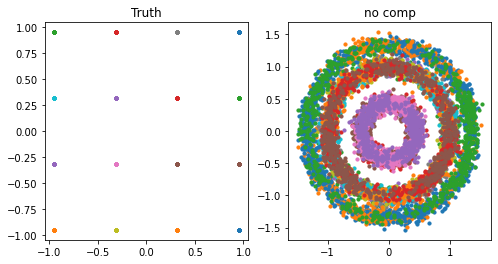

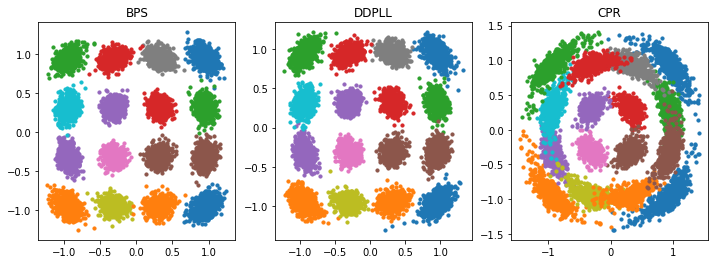

In [292]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
show_symb(truth[:,0], jax.device_get(truth[:,0]))
plt.title('Truth')
plt.subplot(1,2,2)
plt.title('no comp')
show_symb(y[:,0], jax.device_get(truth[:,0]))


plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
show_symb(y1[:,0], jax.device_get(truth[:,0]))
plt.title('BPS')

plt.subplot(1,3,2)
show_symb(y2[:,0], jax.device_get(truth[:,0]))
plt.title('DDPLL')

plt.subplot(1,3,3)
show_symb(y3, jax.device_get(truth[:,0]))
plt.title('CPR')

0.050875


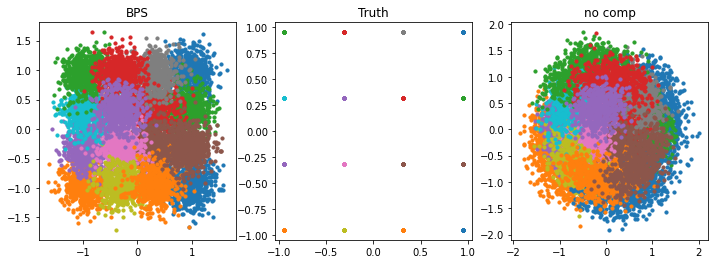

In [297]:
n1 = rd.normal(rd.PRNGKey(0), truth.shape, dtype=jnp.float64)*0.01
n2 = rd.normal(rd.PRNGKey(1), truth.shape, dtype=jnp.complex128)*0.3
pn = jnp.cumsum(n1, axis=0)

y = truth * jnp.exp(1j*pn) + n2

## BPS
theta0 = bps(jax.device_get(y), 51, jax.device_get(constSymb), 101)
theta1 = np.unwrap(4 * theta0, axis=0) / 4
y1 = y*jnp.exp(1j*theta1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
show_symb(y1[:,0], jax.device_get(truth[:,0]))
plt.title('BPS')

plt.subplot(1,3,2)
show_symb(truth, jax.device_get(truth[:,0]))
plt.title('Truth')

plt.subplot(1,3,3)
show_symb(y[:,0], jax.device_get(truth[:,0]))
plt.title('no comp')

res = comm.qamqot(y1[:,0], truth, scale=np.sqrt(10))
ber = res['BER']['dim0']
print(ber)
